In [3]:
import gc
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import GridSpec

In [4]:
from __future__ import absolute_import, division, print_function
import seaborn as sns
import os, sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set_context("poster", font_scale=1.3)

import missingno as msno
import pandas_profiling

from sklearn.datasets import make_blobs
import time

In [5]:
import datetime
%matplotlib inline

In [6]:
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings('ignore')
sns.set_context("poster", font_scale=1.3)
#http://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost

In [7]:
X_train = pd.read_csv('train.csv', parse_dates=['click_time'])
print (X_train.shape)
# Show the head of the table
X_train.head()


(100000, 8)


ip  app  device  os  channel          click_time attributed_time  \
0   87540   12       1  13      497 2017-11-07 09:30:38             NaN   
1  105560   25       1  17      259 2017-11-07 13:40:27             NaN   
2  101424   12       1  19      212 2017-11-07 18:05:24             NaN   
3   94584   13       1  13      477 2017-11-07 04:58:08             NaN   
4   68413   12       1   1      178 2017-11-09 09:00:09             NaN   

   is_attributed  
0              0  
1              0  
2              0  
3              0  
4              0

In [7]:
pandas_profiling.ProfileReport(X_train)

In [8]:
test = pd.read_csv('test.csv')
test.head()

click_id      ip  app  device  os  channel           click_time
0         0    5744    9       1   3      107  2017-11-10 04:00:00
1         1  119901    9       1   3      466  2017-11-10 04:00:00
2         2   72287   21       1  19      128  2017-11-10 04:00:00
3         3   78477   15       1  13      111  2017-11-10 04:00:00
4         4  123080   12       1  13      328  2017-11-10 04:00:00

In [9]:
test.shape

(18790469, 7)

## Analysis of data sets based on statistics

1.ip, app, device, os and channel are actually categorical variables encoded as integers. Set them as categories for analysis.

In [10]:
variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    X_train[v] = X_train[v].astype('category')
    test[v]=test[v].astype('category')

2.Convert date stamps to date/time type

In [11]:
#set click_time and attributed_time as timeseries
X_train['click_time'] = pd.to_datetime(X_train['click_time'])
X_train['attributed_time'] = pd.to_datetime(X_train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

#set as_attributed in train as a categorical
X_train['is_attributed']=X_train['is_attributed'].astype('category')

In [12]:
X_train.describe()

ip       app    device        os   channel           click_time  \
count   100000.0  100000.0  100000.0  100000.0  100000.0               100000   
unique   34857.0     161.0     100.0     130.0     161.0                80350   
top       5348.0       3.0       1.0      19.0     280.0  2017-11-08 12:01:02   
freq       669.0   18279.0   94338.0   23870.0    8114.0                    7   
first        NaN       NaN       NaN       NaN       NaN  2017-11-06 16:00:00   
last         NaN       NaN       NaN       NaN       NaN  2017-11-09 15:59:51   

            attributed_time  is_attributed  
count                   227       100000.0  
unique                  227            2.0  
top     2017-11-09 00:21:23            0.0  
freq                      1        99773.0  
first   2017-11-06 17:19:04            NaN  
last    2017-11-09 15:28:15            NaN

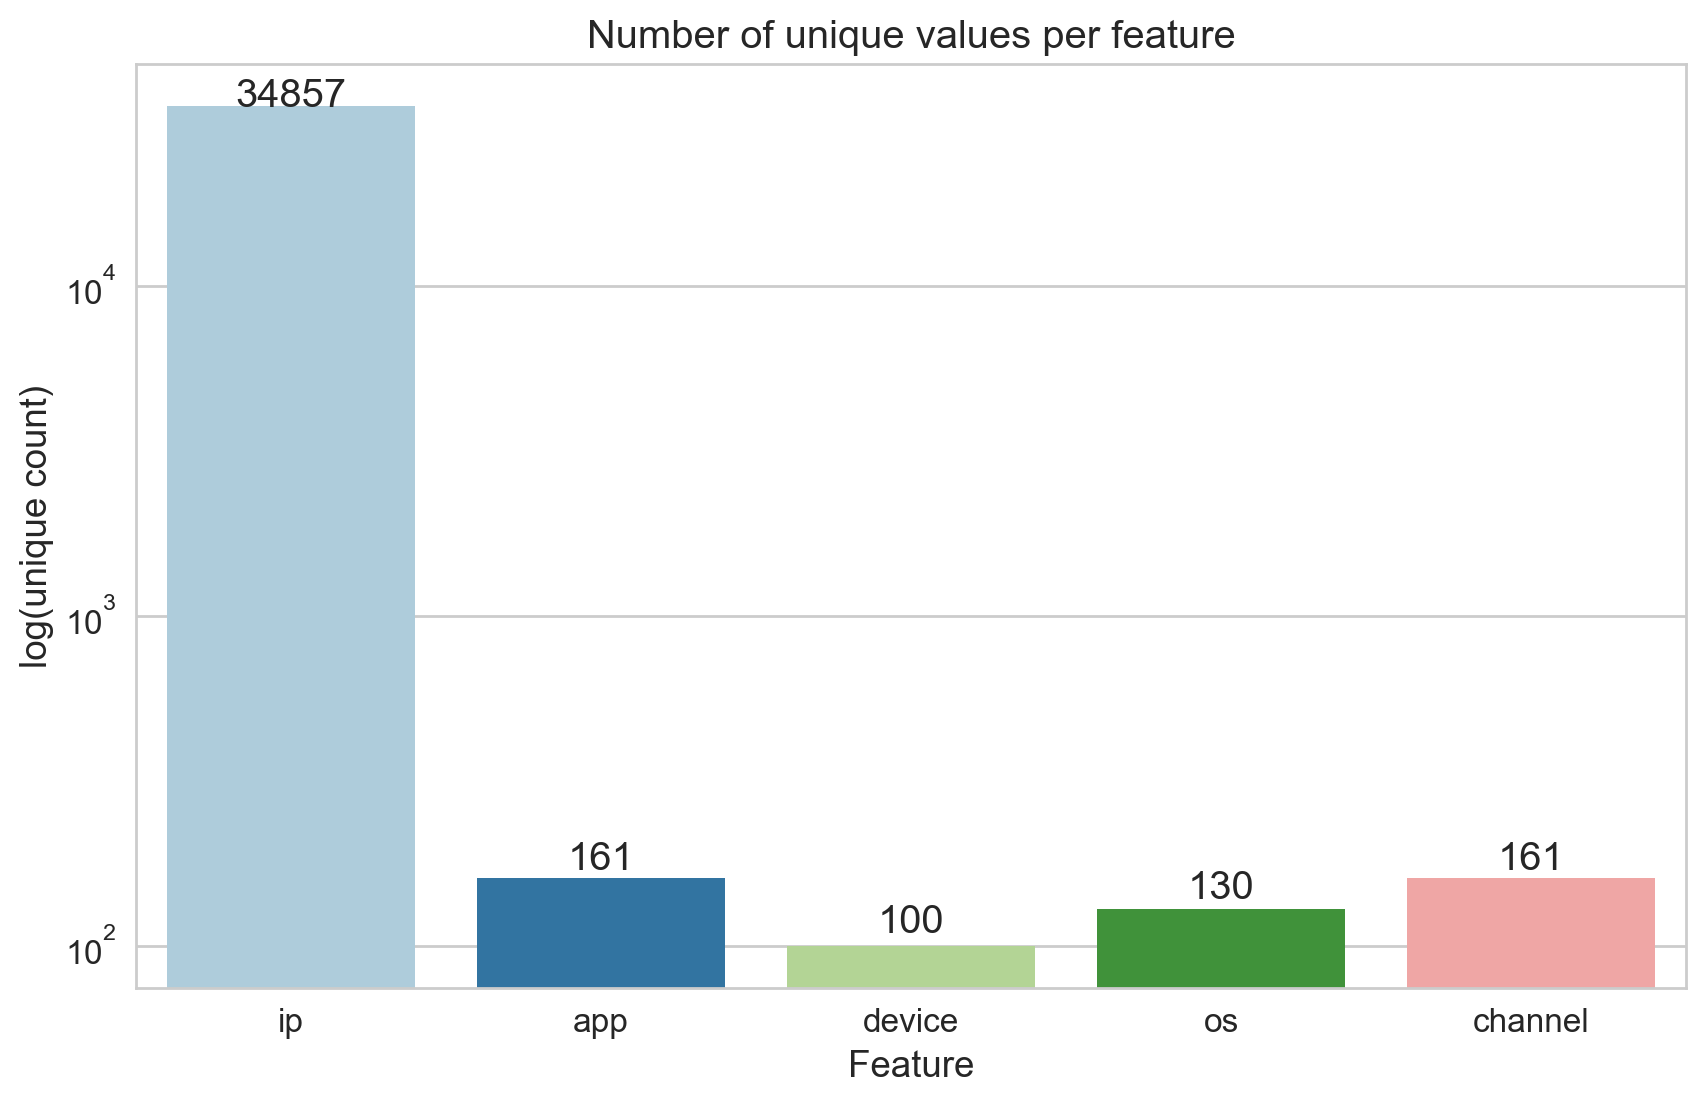

In [13]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(X_train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
ax = sns.barplot(cols, uniques, log=True,palette=sns.color_palette("Paired",5))
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 
# for col, uniq in zip(cols, uniques):
#     ax.text(col, uniq, uniq, color='black', ha="center")

4.Quick check to make sure that Nan values in 'attribute_time' are only for samples that did not convert. Check that counts of 'attributed_time' values is same as count of converted clicks.

In [146]:
X_train[['attributed_time', 'is_attributed']][X_train['is_attributed']==1].describe()

attributed_time  is_attributed
count                   227          227.0
unique                  227            1.0
top     2017-11-08 06:19:51            1.0
freq                      1          227.0
first   2017-11-06 17:19:04            NaN
last    2017-11-09 15:28:15            NaN

5.Missing data

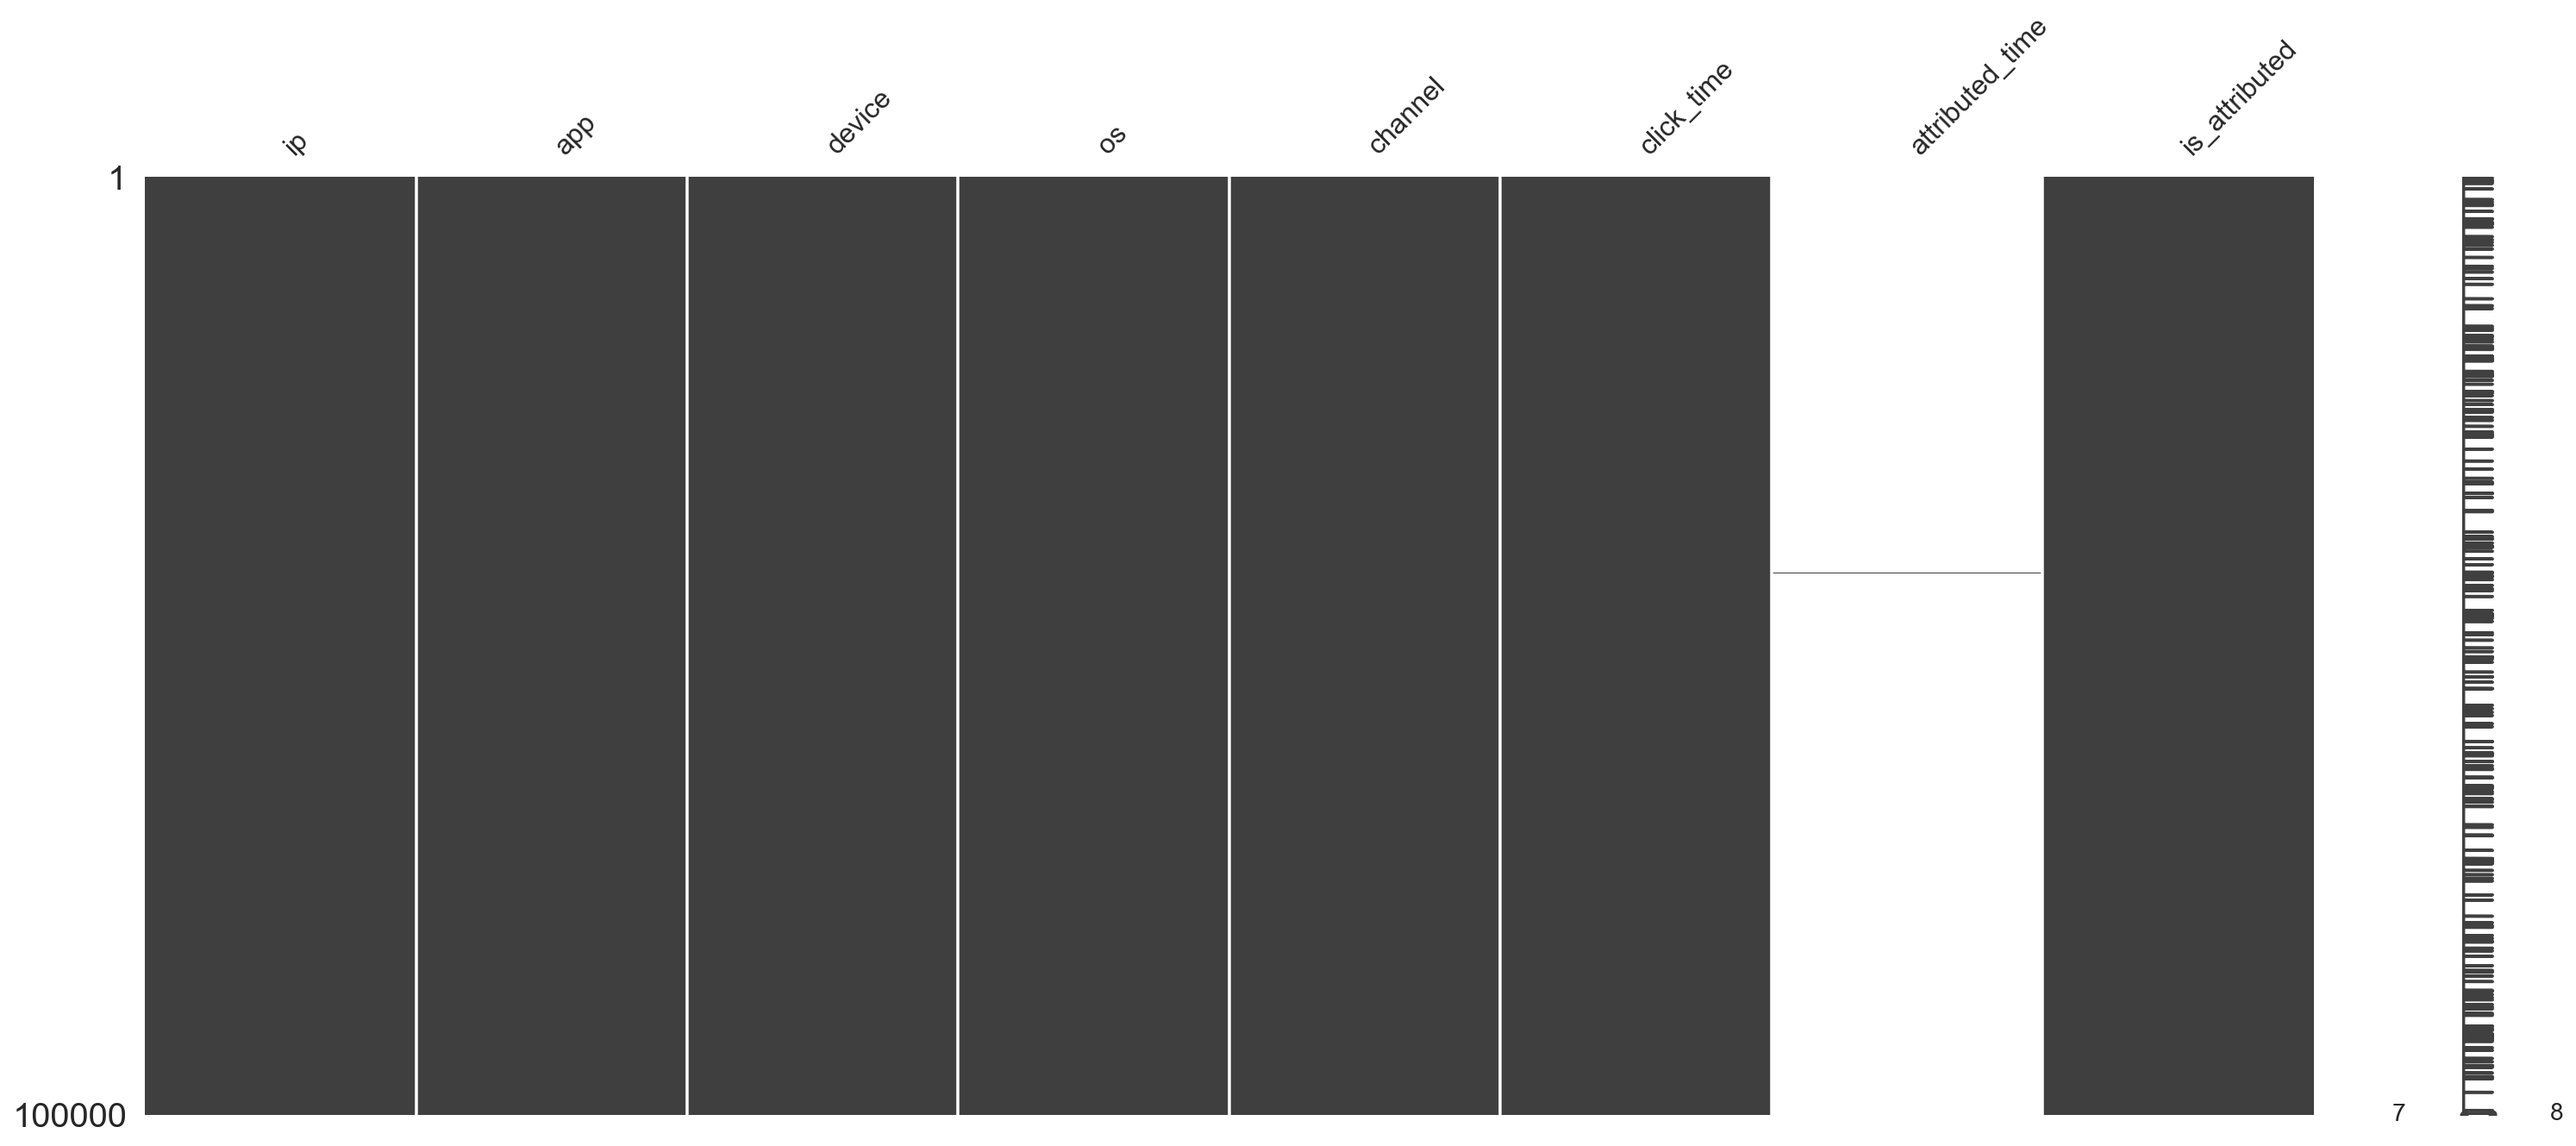

In [148]:
import missingno as msno
%matplotlib inline
msno.matrix(X_train.sample(100000))

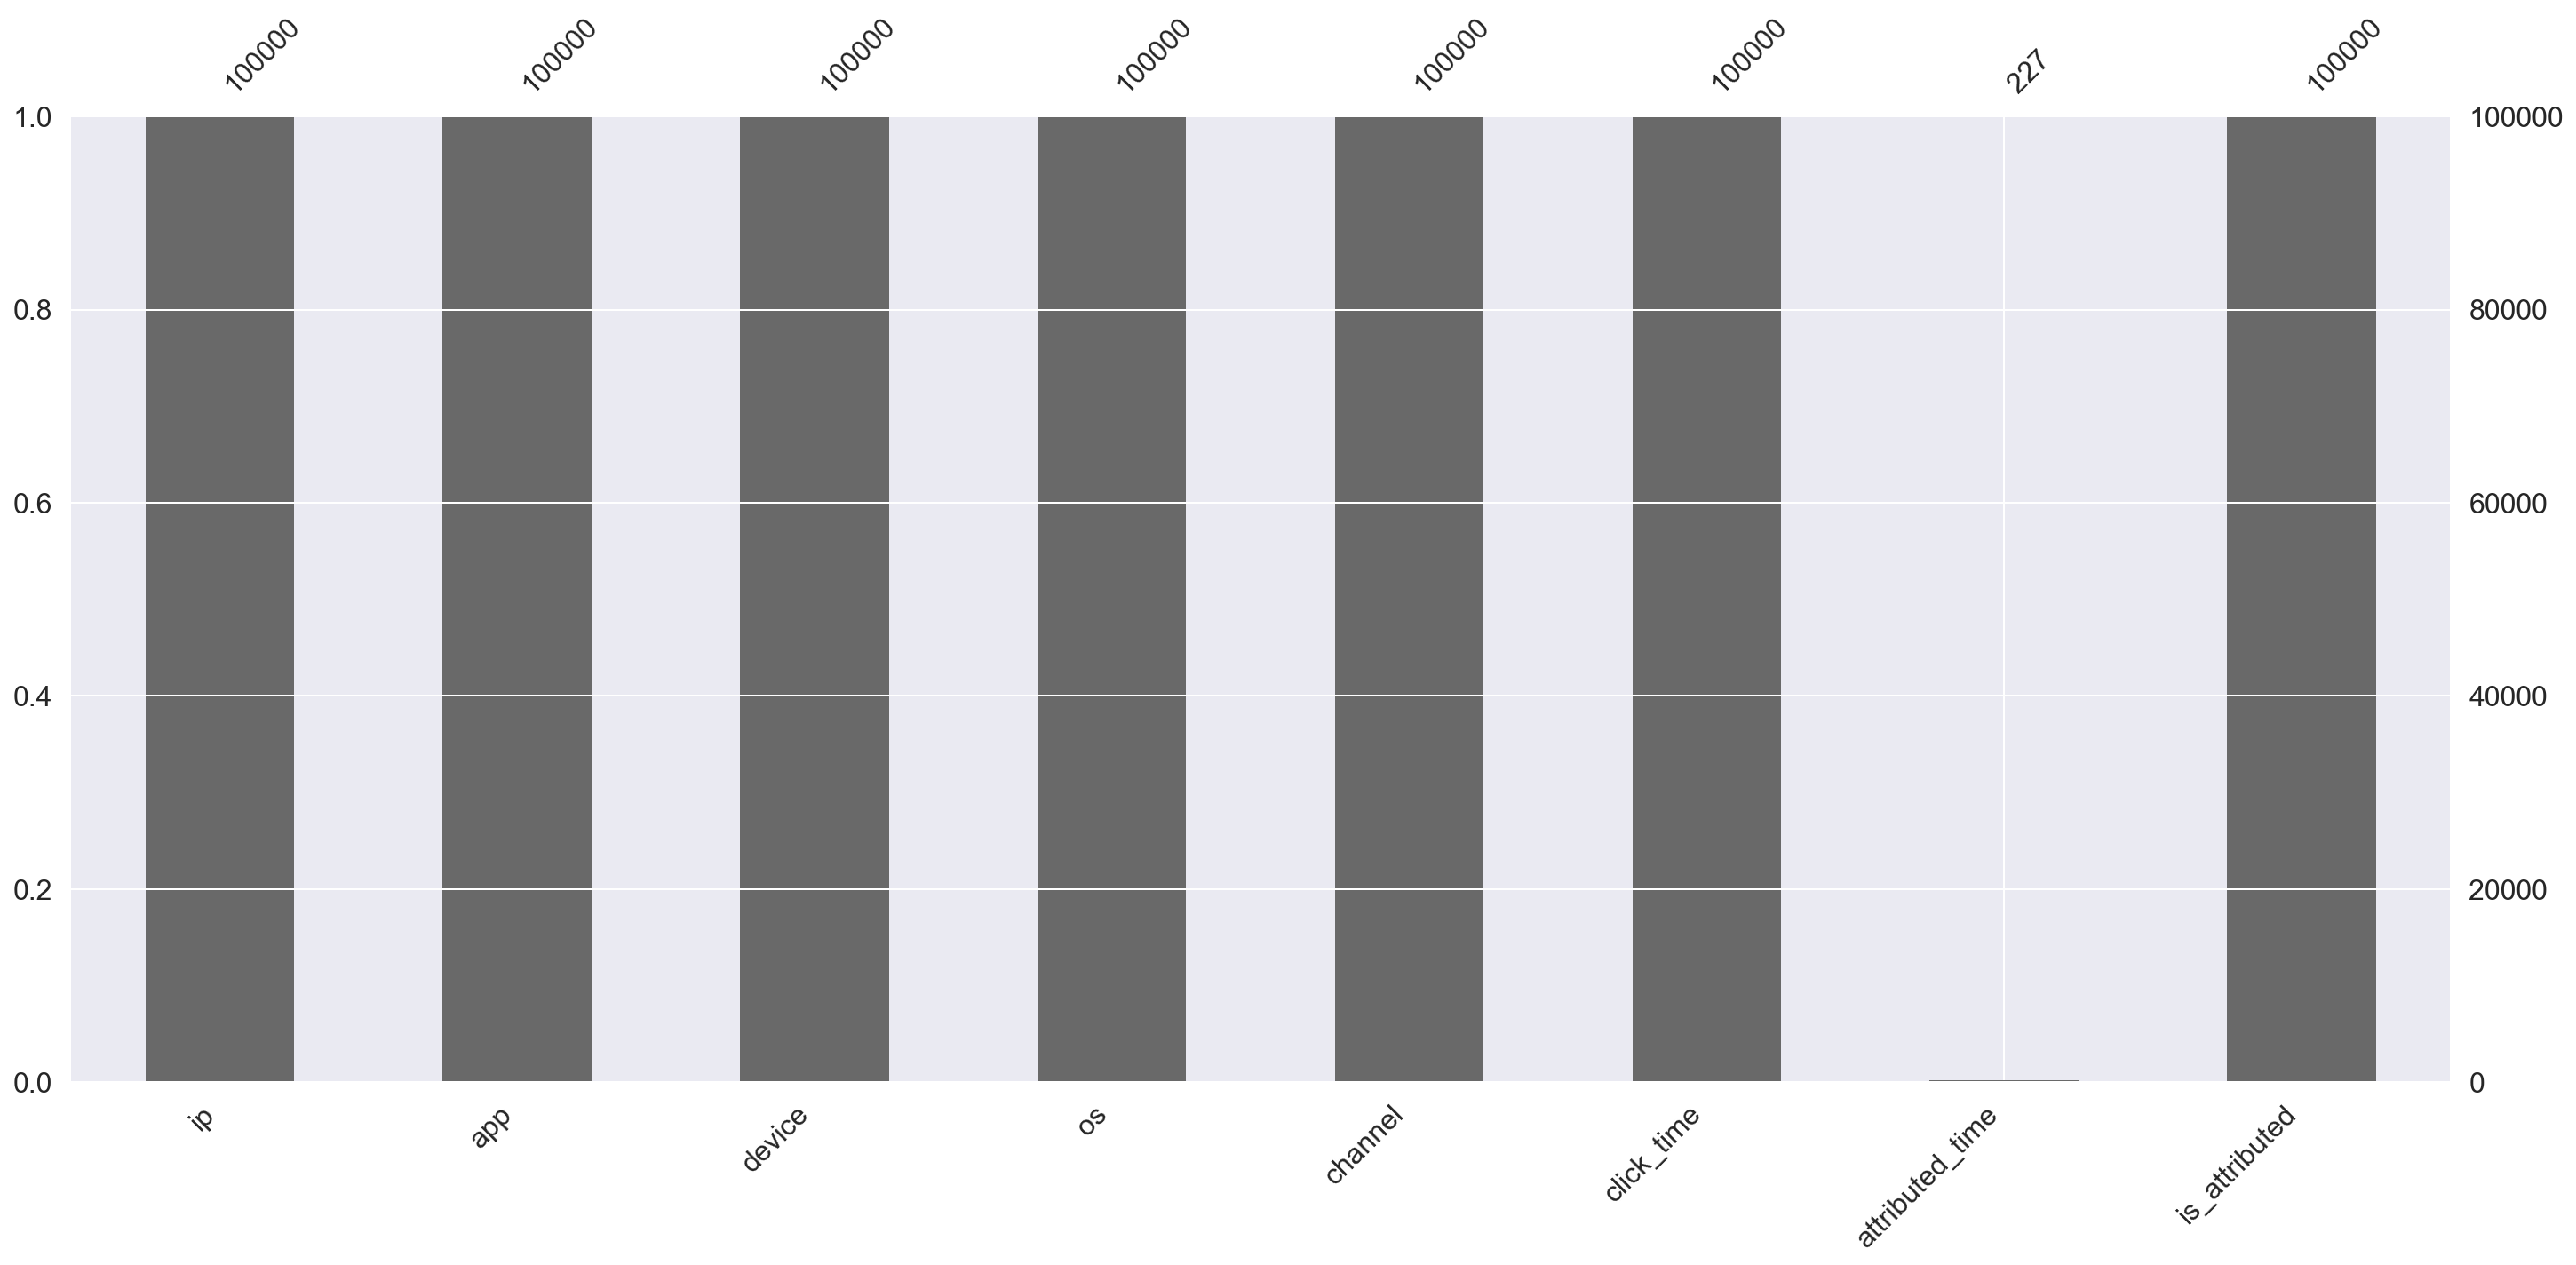

In [149]:
msno.bar(X_train.sample(100000))

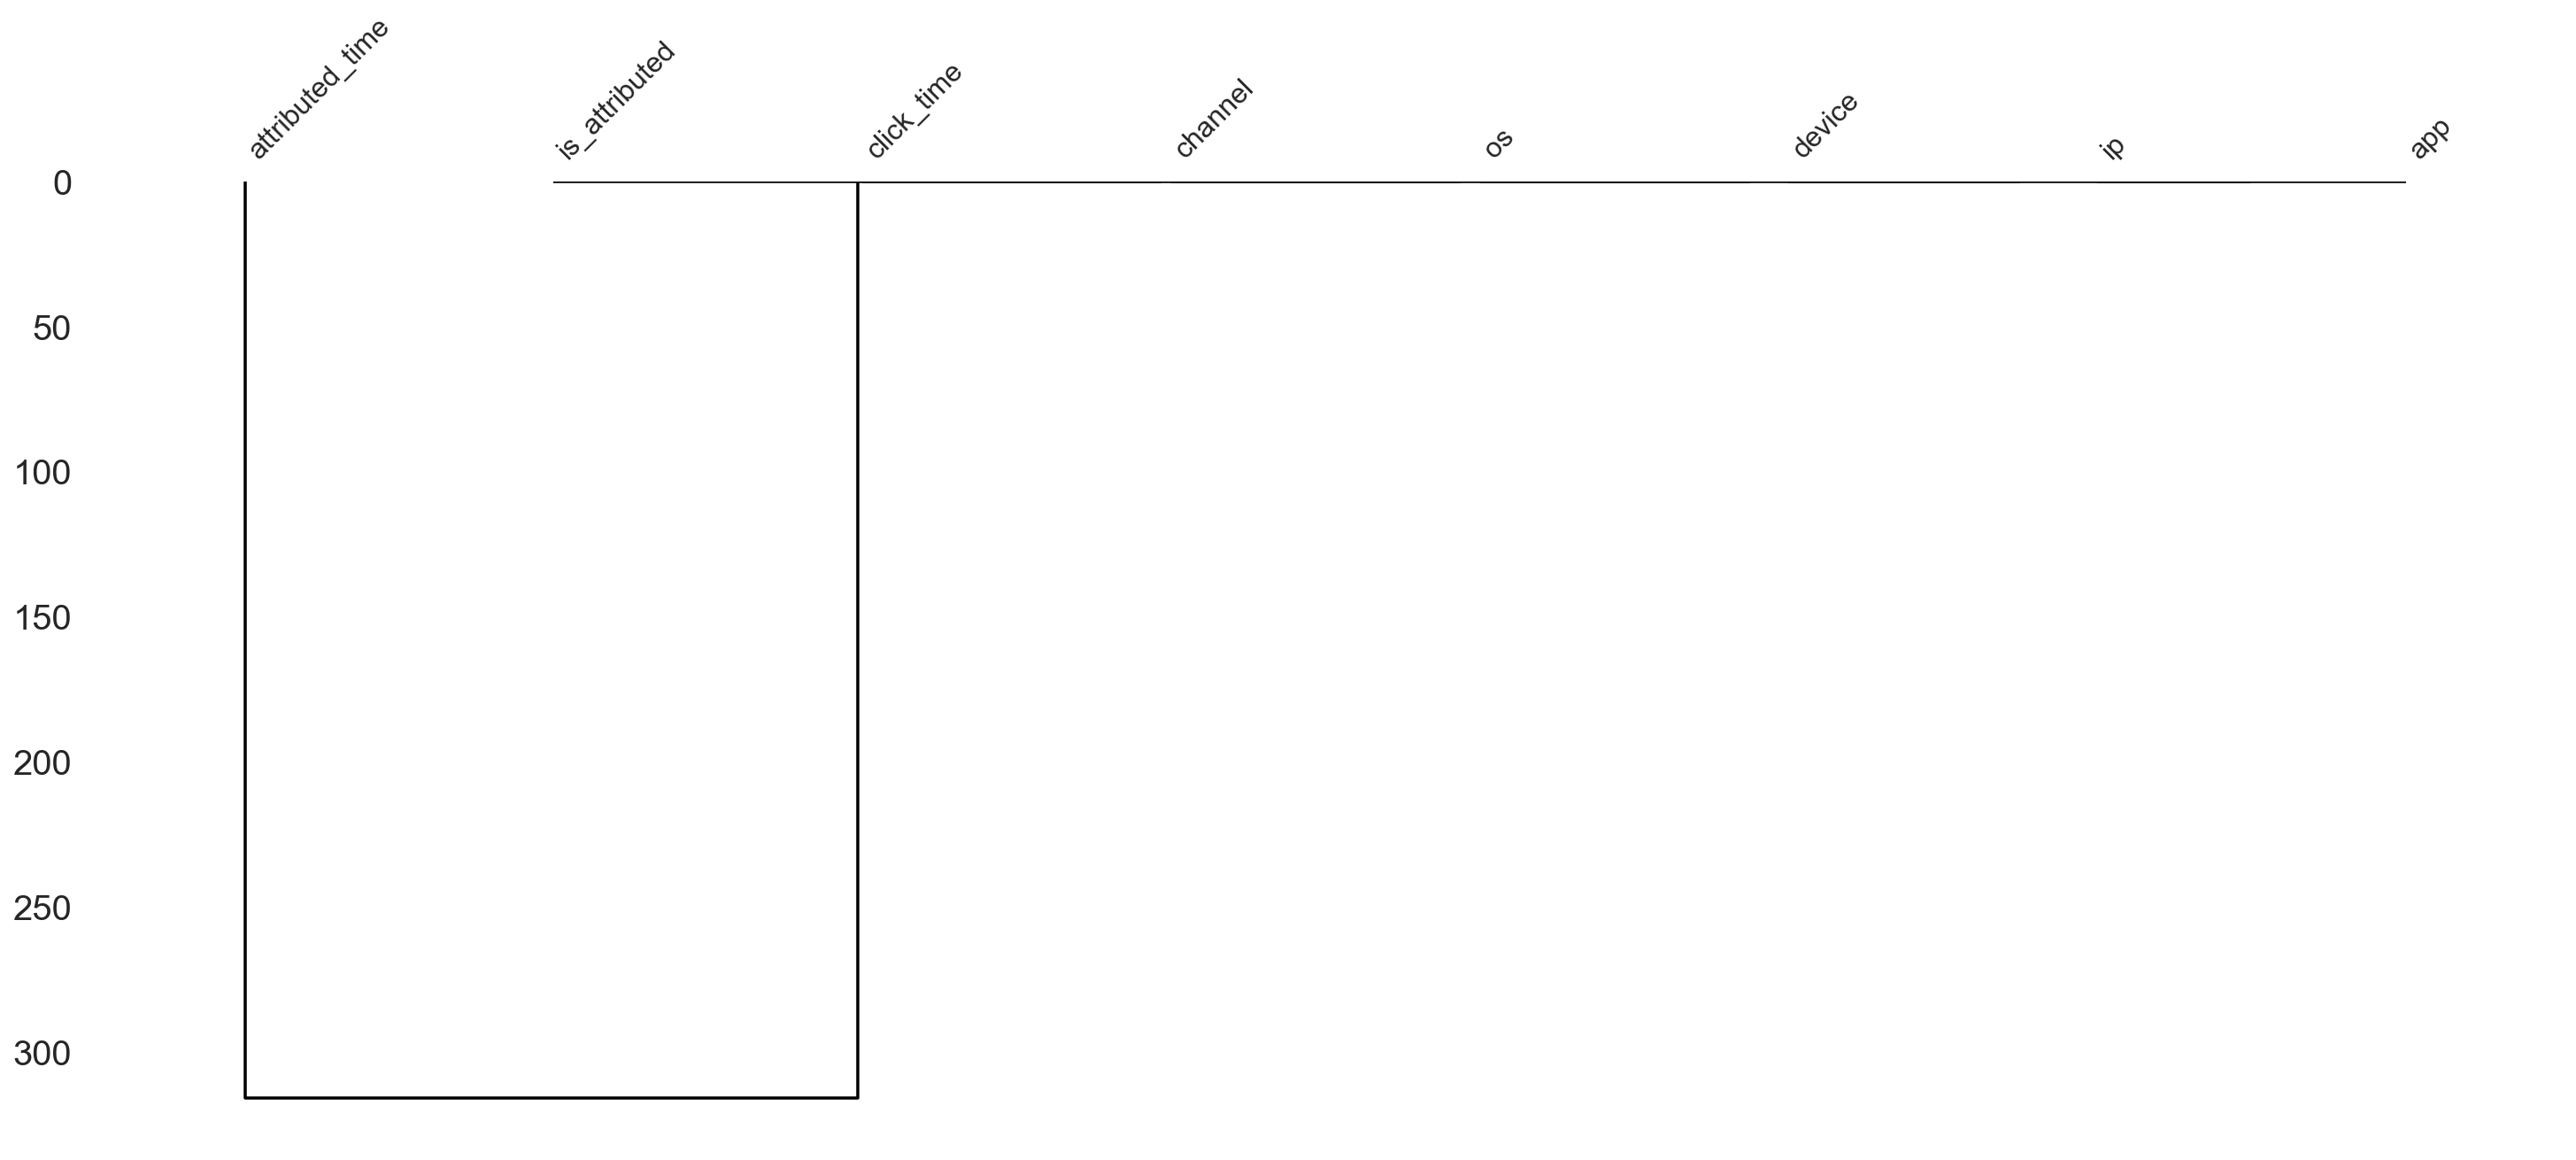

In [150]:
msno.dendrogram(X_train)

In [151]:
test['click_id']=test['click_id'].astype('category')
test.describe()

click_id          ip         app      device          os  \
count   18790469.0  18790469.0  18790469.0  18790469.0  18790469.0   
unique  18790469.0     93936.0       417.0      1985.0       395.0   
top     18790468.0      5348.0         9.0         1.0        19.0   
freq           1.0    182522.0   2872176.0  17360269.0   4334532.0   
first          NaN         NaN         NaN         NaN         NaN   
last           NaN         NaN         NaN         NaN         NaN   

           channel           click_time  
count   18790469.0             18790469  
unique       178.0                21603  
top          107.0  2017-11-10 09:00:10  
freq     1214650.0                 1466  
first          NaN  2017-11-10 04:00:00  
last           NaN  2017-11-10 15:00:00

## Outlier detection

In [16]:
X_train.duplicated()
X_train.drop_duplicates()
print (X_train.shape)

(10000000, 8)


In [17]:
columns = X_train.columns.tolist()
columns

['ip',
 'app',
 'device',
 'os',
 'channel',
 'click_time',
 'attributed_time',
 'is_attributed']

In [18]:
all_cols_unique_ip = X_train.groupby('ip').agg({col:'nunique' for col in columns})

In [19]:
all_cols_unique_ip.head()

ip  app  device  os  channel  click_time  attributed_time  is_attributed
ip                                                                          
9    1   19       2  10       43         112                0              1
10   1   22       1  11       38          62                0              1
19   1   16       1   6       24          27                0              1
20   1   20       4  12       42         168                0              1
25   1   14       2  12       20          40                1              2

In [20]:
cols=['ip','app','device','os','channel','click_time']

In [25]:
error=all_cols_unique_ip[all_cols_unique_ip['is_attributed']  >1][all_cols_unique_ip['app']==1][all_cols_unique_ip['device']==1][all_cols_unique_ip['os']==1][all_cols_unique_ip['channel']==1][all_cols_unique_ip['click_time']==1]
error.head()

ip  app  device  os  channel  click_time  attributed_time  \
ip                                                                  
126446   1    1       1   1        1           1                1   
126836   1    1       1   1        1           1                1   
127417   1    1       1   1        1           1                1   
127818   1    1       1   1        1           1                1   
128482   1    1       1   1        1           1                1   

        is_attributed  
ip                     
126446              2  
126836              2  
127417              2  
127818              2  
128482              2

In [22]:
X_train[X_train['ip']==126446]

ip app device  os channel          click_time  \
7254879  126446  29      1  19     213 2017-11-06 23:09:48   
7254928  126446  29      1  19     213 2017-11-06 23:09:48   

            attributed_time is_attributed  
7254879 2017-11-06 23:10:32             1  
7254928                 NaT             0

In [146]:
X_train[X_train['ip']==212634]

ip  app  device  os  channel          click_time  \
662596  212634   29       1  16      101 2017-11-06 16:13:44   
662683  212634   29       1  16      101 2017-11-06 16:13:44   

            attributed_time  is_attributed  
662596  2017-11-06 16:16:35              1  
662683                  NaN              0

In [147]:
X_train.drop(X_train.index[[662596,662596]],inplace=True)
X_train.drop(X_train.index[[662683,662683]],inplace=True)

In [148]:
X_train.shape

(999959, 8)

In [149]:
X_train.to_csv(path_or_buf='X_train_no_error.csv', index = False)

## Statistical analysis

In [9]:
train = pd.read_csv('train.csv', nrows=10000000,parse_dates=['click_time'])

In [11]:
train.shape

(10000000, 8)

In [13]:
variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    train[v] = train[v].astype('category')
    #test[v]=test[v].astype('category')

In [17]:
#set click_time and attributed_time as timeseries
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

#set as_attributed in train as a categorical
train['is_attributed']=train['is_attributed'].astype('category')

0.0018717


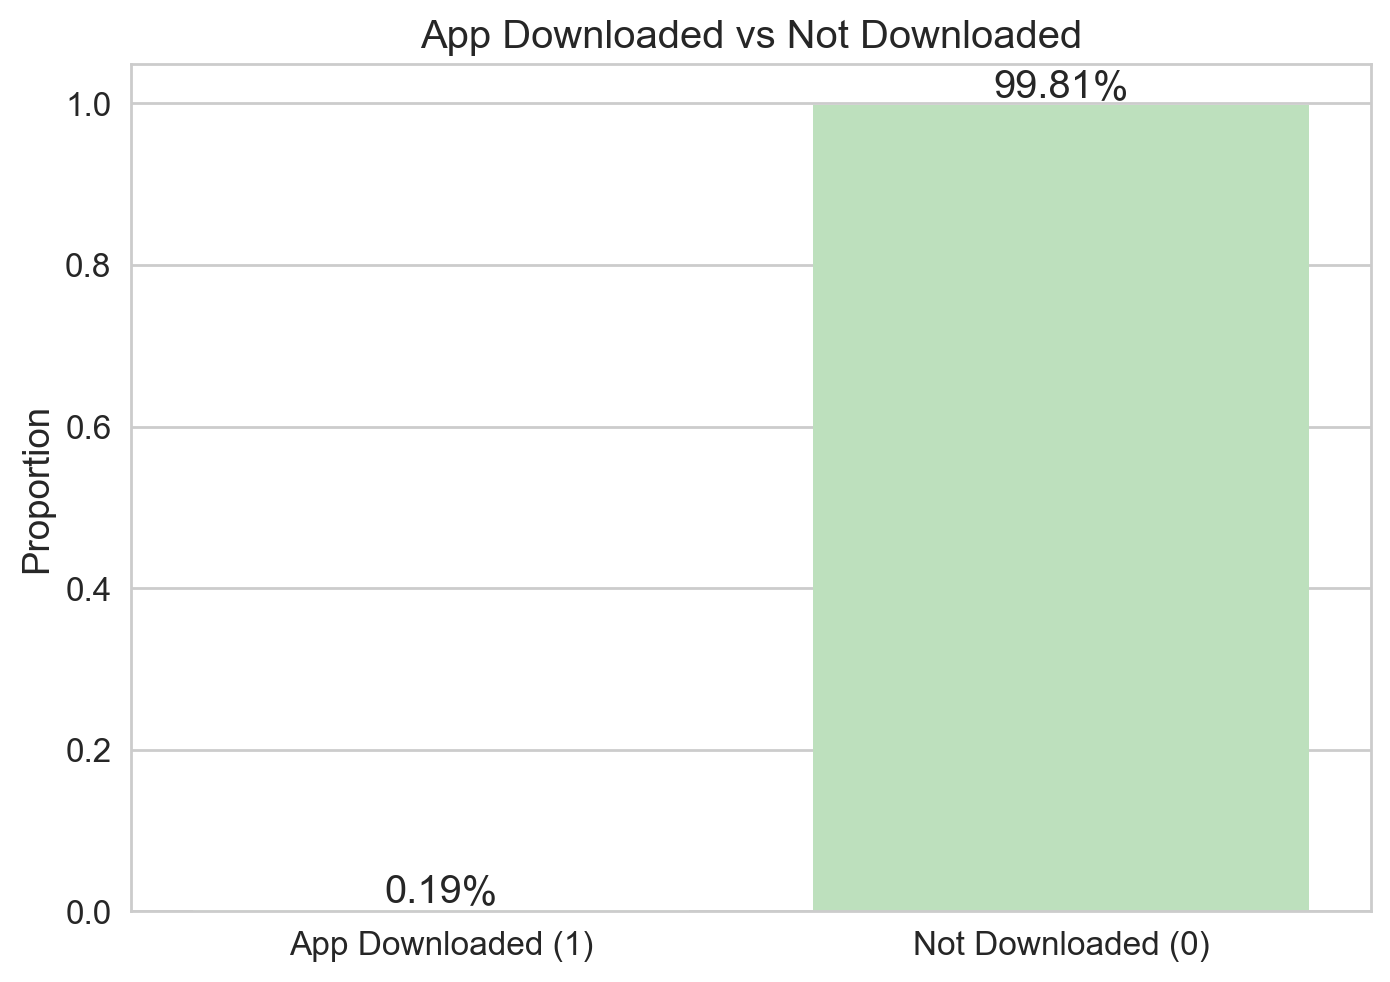

In [18]:

sns.set(font_scale=1.2)
sns.set_style("whitegrid")
mean = (train.is_attributed.values == 1).mean()
print(mean)
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean],palette=sns.light_palette("green"))
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

At this point I was trying to figure out what 'ip' were actually encoding. My original understanding that ips were user specific did not hold up to scrutiny. If ip repeated too many times, was it a bot? This does not appear to be true, as repeated ips do convert. See below:

In [19]:
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

ip  counts
0   73516   51711
1   73487   51215
2    5314   35073
3    5348   35004
4   53454   25381
5  105560   23289
6  100275   23070
7  114276   22774
8  201182   22719
9  105475   22047

In [20]:
train= train.merge(temp, on='ip', how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [21]:
train.head()

ip app device  os channel          click_time attributed_time  \
0   83230   3      1  13     379 2017-11-06 14:32:21             NaT   
1   17357   3      1  19     379 2017-11-06 14:33:34             NaT   
2   35810   3      1  13     379 2017-11-06 14:34:12             NaT   
3   45745  14      1  13     478 2017-11-06 14:34:52             NaT   
4  161007   3      1  13     379 2017-11-06 14:35:08             NaT   

  is_attributed  counts  
0             0    1327  
1             0    1057  
2             0     449  
3             0    9395  
4             0     184

In [60]:
train[train['is_attributed']==1].sort_values('counts', ascending=False)[:5]

ip app device  os channel          click_time     attributed_time  \
7912764  73516  34      1  19     243 2017-11-06 23:28:13 2017-11-07 01:13:45   
289189   73516  19   3033  21     213 2017-11-06 16:05:33 2017-11-06 16:05:52   
3350587  73516  72      1  18     101 2017-11-06 17:46:37 2017-11-07 09:46:44   
3416495  73516  10      1  25     377 2017-11-06 17:50:33 2017-11-06 18:50:59   
6331848  73516  29      1  14     213 2017-11-06 22:36:25 2017-11-07 02:10:05   

         is_attributed  counts           click_rnd  
7912764              1   51711 2017-11-06 23:00:00  
289189               1   51711 2017-11-06 16:00:00  
3350587              1   51711 2017-11-06 18:00:00  
3416495              1   51711 2017-11-06 18:00:00  
6331848              1   51711 2017-11-06 23:00:00

In [23]:
train[train['is_attributed']==1].ip.describe()

count     18717
unique    16112
top       73487
freq         56
Name: ip, dtype: int64

ip=73487,点击量是第二多的共有51215次点击，下载量是56次，转化次数最多的IP，所以不应该是bot，那么也就是这个点击的IP地址并不是每个人的

这里我们把train['is_attributed']的数据类型从分类转化回数字。

In [24]:
train['is_attributed']=train['is_attributed'].astype(int)

In [ ]:
sns.set_style("white")

proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']


print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])
top=merge[0:100]
x=top['ip'].index
ycount=top['click_count']
yprop=top['prop_downloaded']

fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Rank")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, yprop, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')
plt.title('Conversion Rates of 100 Most Popular IPs')

In [ ]:
merge.head()

Conversions are noisy and do not appear to correlate with how popular an IP is. 我们可以看出来准化率的图是有很多噪音的，说明两者并没有关系。

Text(0.5,1,'Conversion Rates of 100 User Groups')

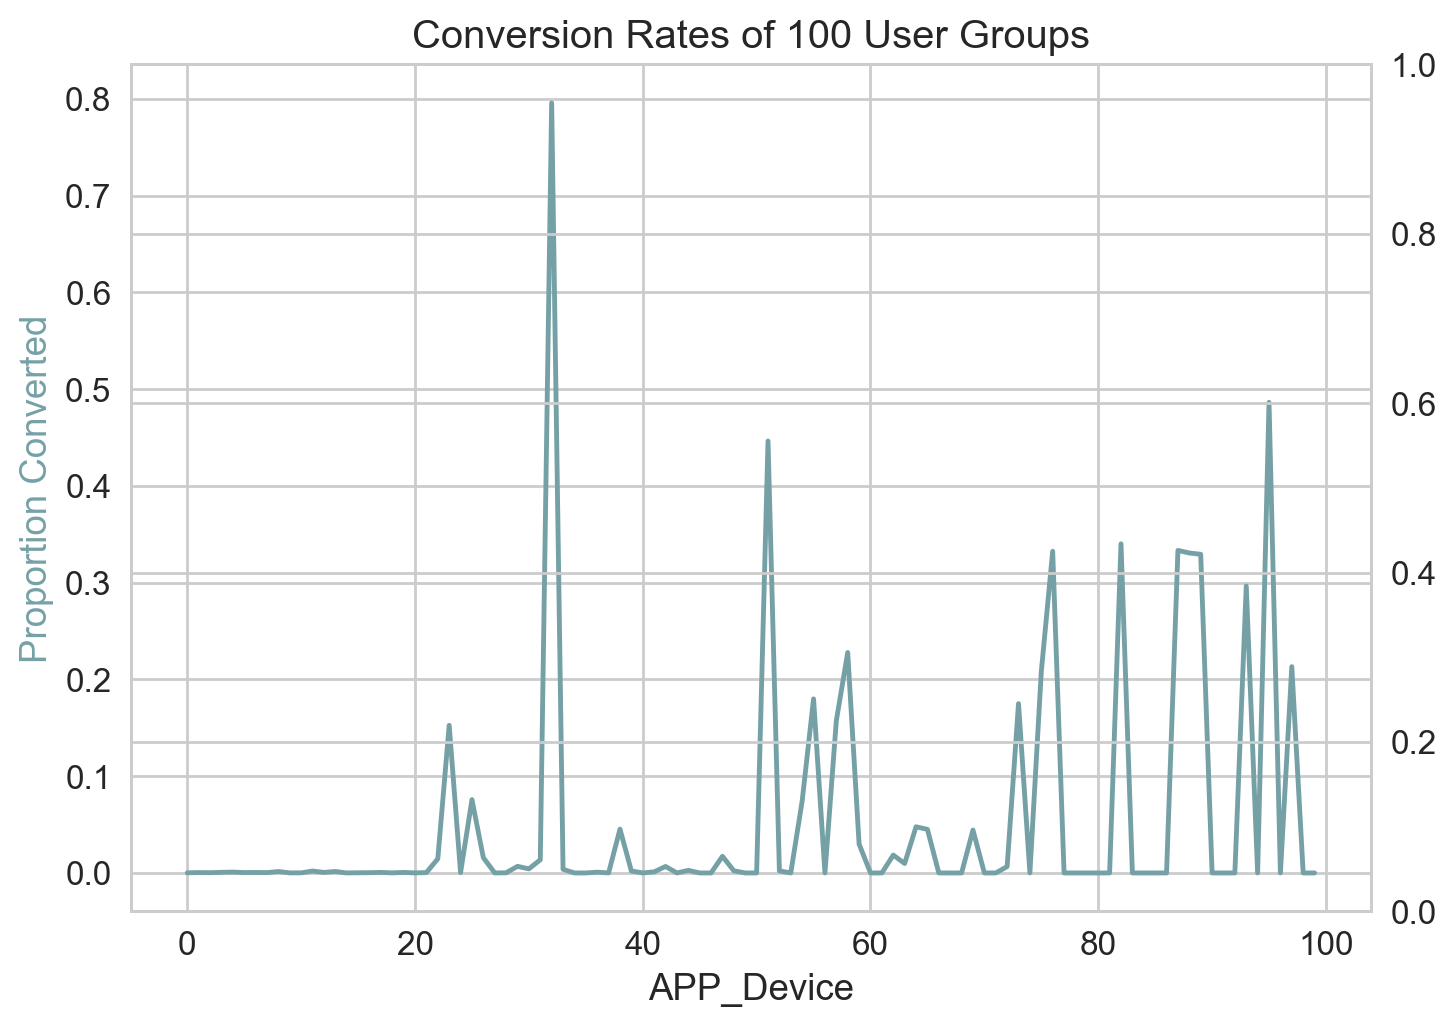

In [29]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

top=merge[0:100]
x=top['app'].index
ycount=top['click_count']
yprop=top['prop_downloaded']

fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("APP_Device")
host.set_ylabel("Proportion Converted")
#par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, yprop, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')
plt.title('Conversion Rates of 100 User Groups')


There is a again a huge difference in clicks per app, with minimum of one click on an app and max at almost 13 million. The proportion flucuates more as the counts go down, since each additional click has larger impact on the proportion value. In general, for apps with counts in the thousands the ratio stays within 0.0001 - 0.0015 boundary. For less popular apps it fluxuates more widely.

Text(0.5,1,'Conversion Rates of 100 User Groups')

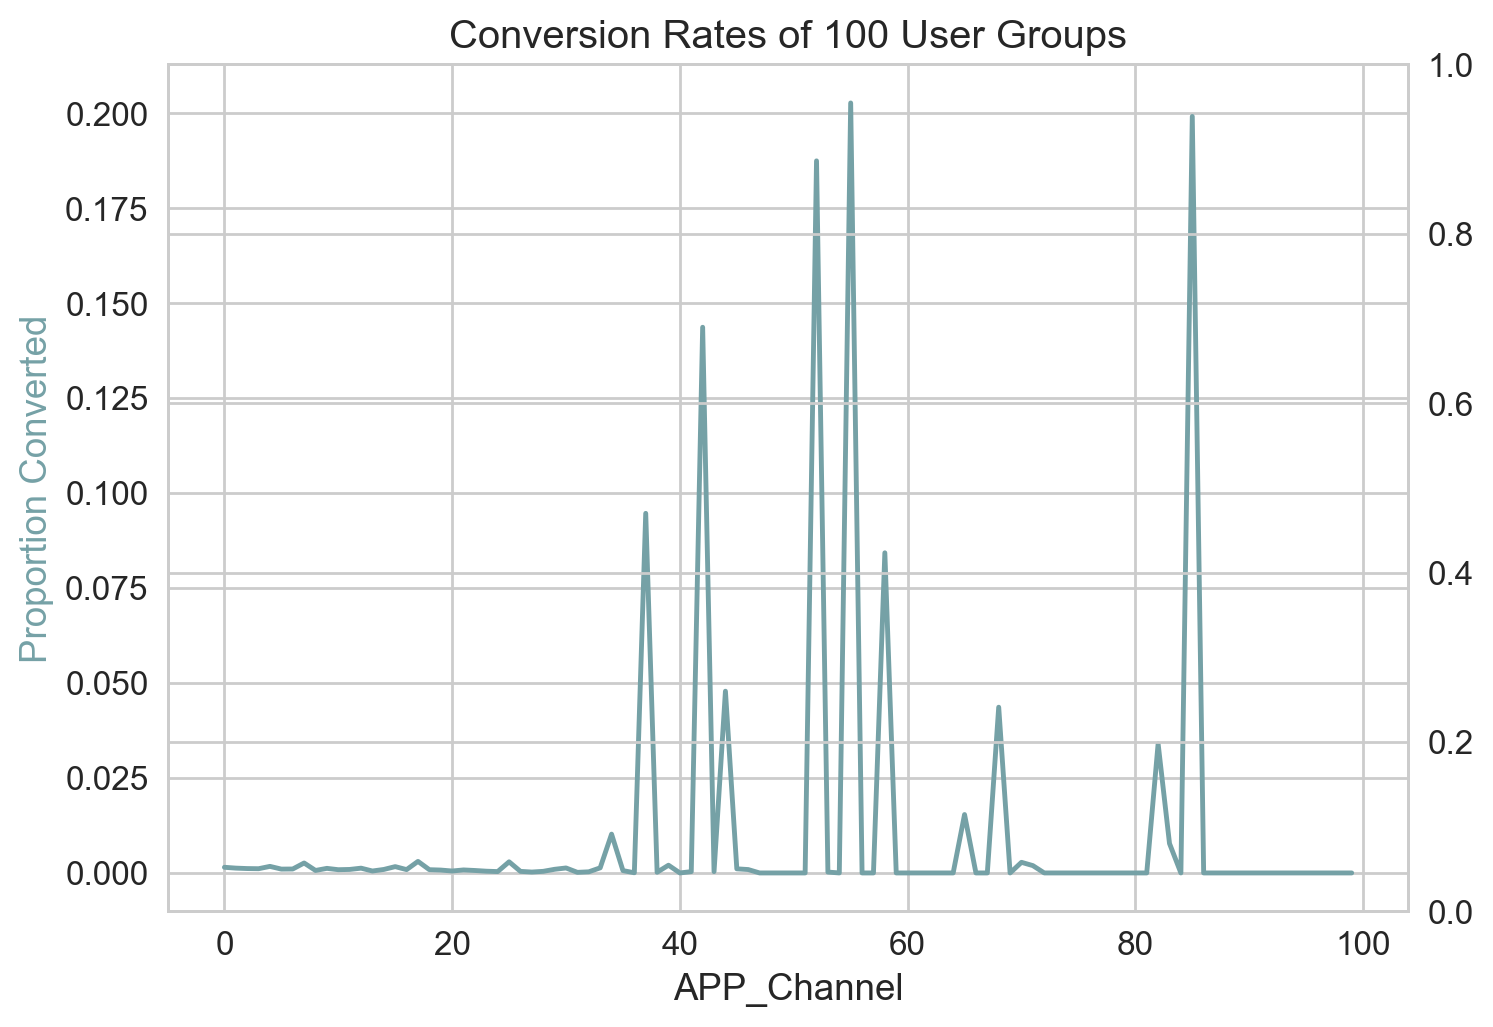

In [33]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

top=merge[0:100]
x=top['os'].index
ycount=top['click_count']
yprop=top['prop_downloaded']

fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("APP_Channel")
host.set_ylabel("Proportion Converted")
#par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, yprop, color=color1,label="Proportion Converted")
#p2, = par1.plot(x, ycount, color=color2, label="Click Count")

#lns = [p1, p2]
#host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
#par1.yaxis.label.set_color(p2.get_color())

#plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')
plt.title('Conversion Rates of 100 User Groups')

0.4609926


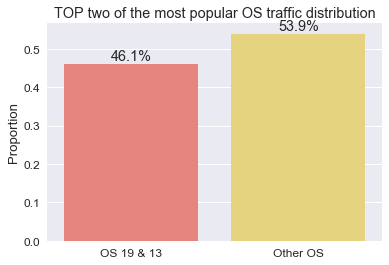

In [129]:
sns.set(font_scale=1.2)
mean=(2410148+2199778)/merge.click_count.sum()
print(mean)

ax = sns.barplot(['OS 19 & 13', 'Other OS'], [mean, 1-mean],palette=sns.hls_palette(8, l=.7, s=.9))
ax.set(ylabel='Proportion', title='TOP two of the most popular OS traffic distribution')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

## 设备和下载比例

In [37]:
sns.set_style("whitegrid")

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Text(0.5,1,'Conversion Rates of 100 Most Popular Devices')

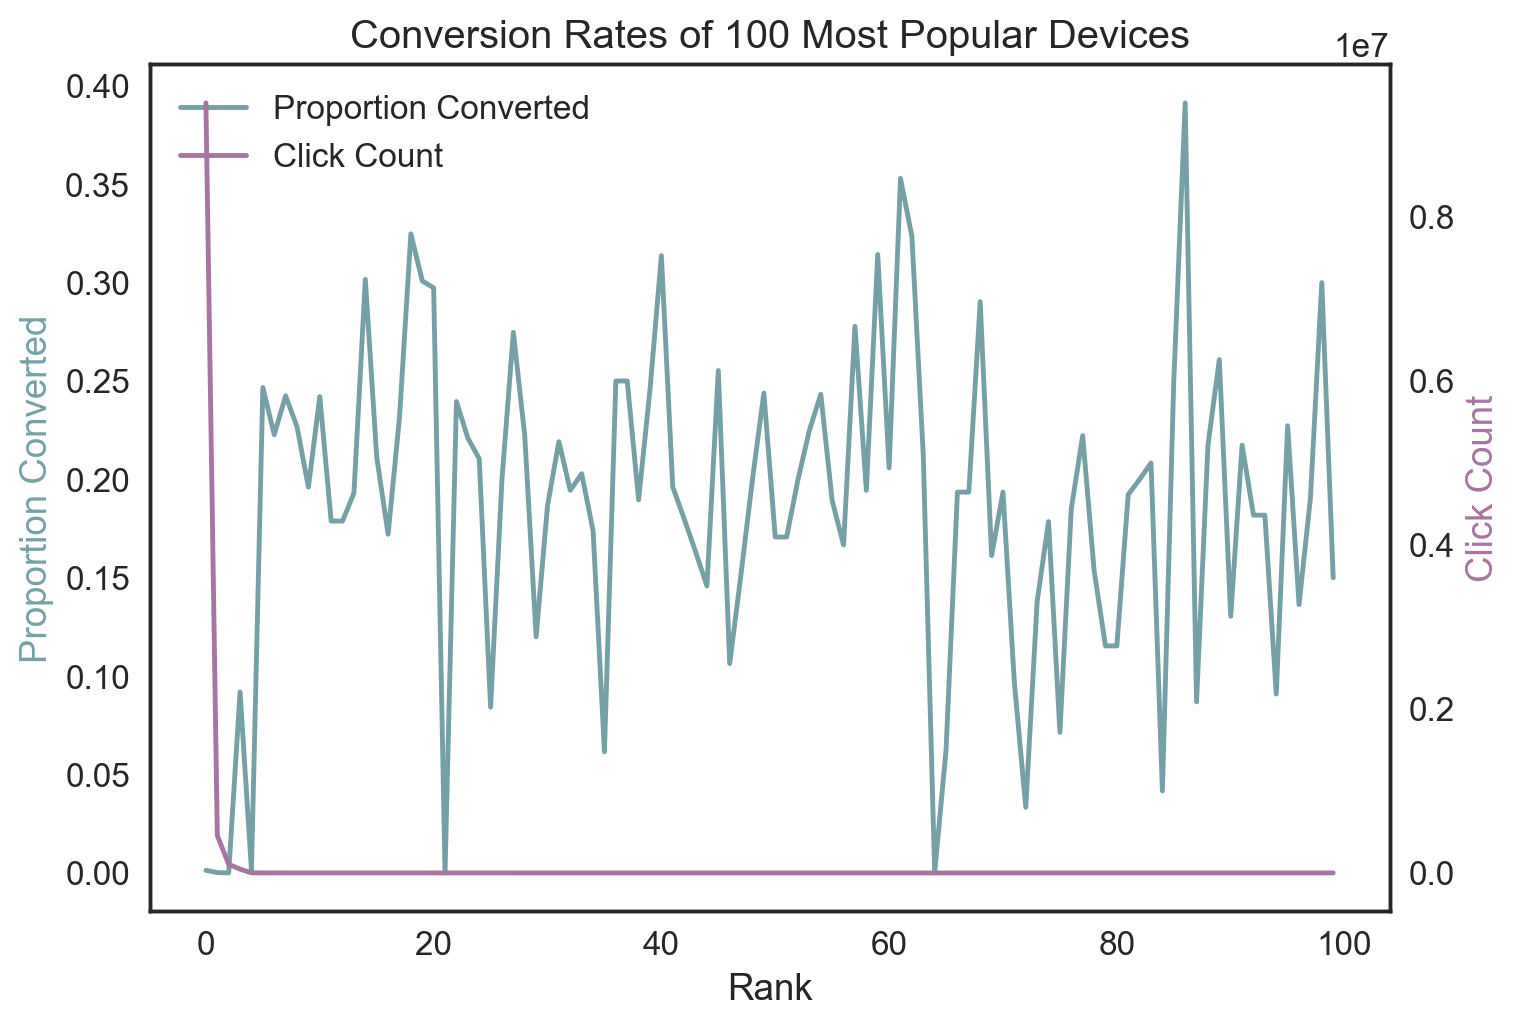

In [50]:
proportion = train[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

top=merge[0:100]
x=top['device'].index
ycount=top['click_count']
yprop=top['prop_downloaded']

fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Rank")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, yprop, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')
plt.title('Conversion Rates of 100 Most Popular Devices')


In [78]:
merge[:1]

device  click_count  prop_downloaded
0      1      9381146         0.001326

0.9381146


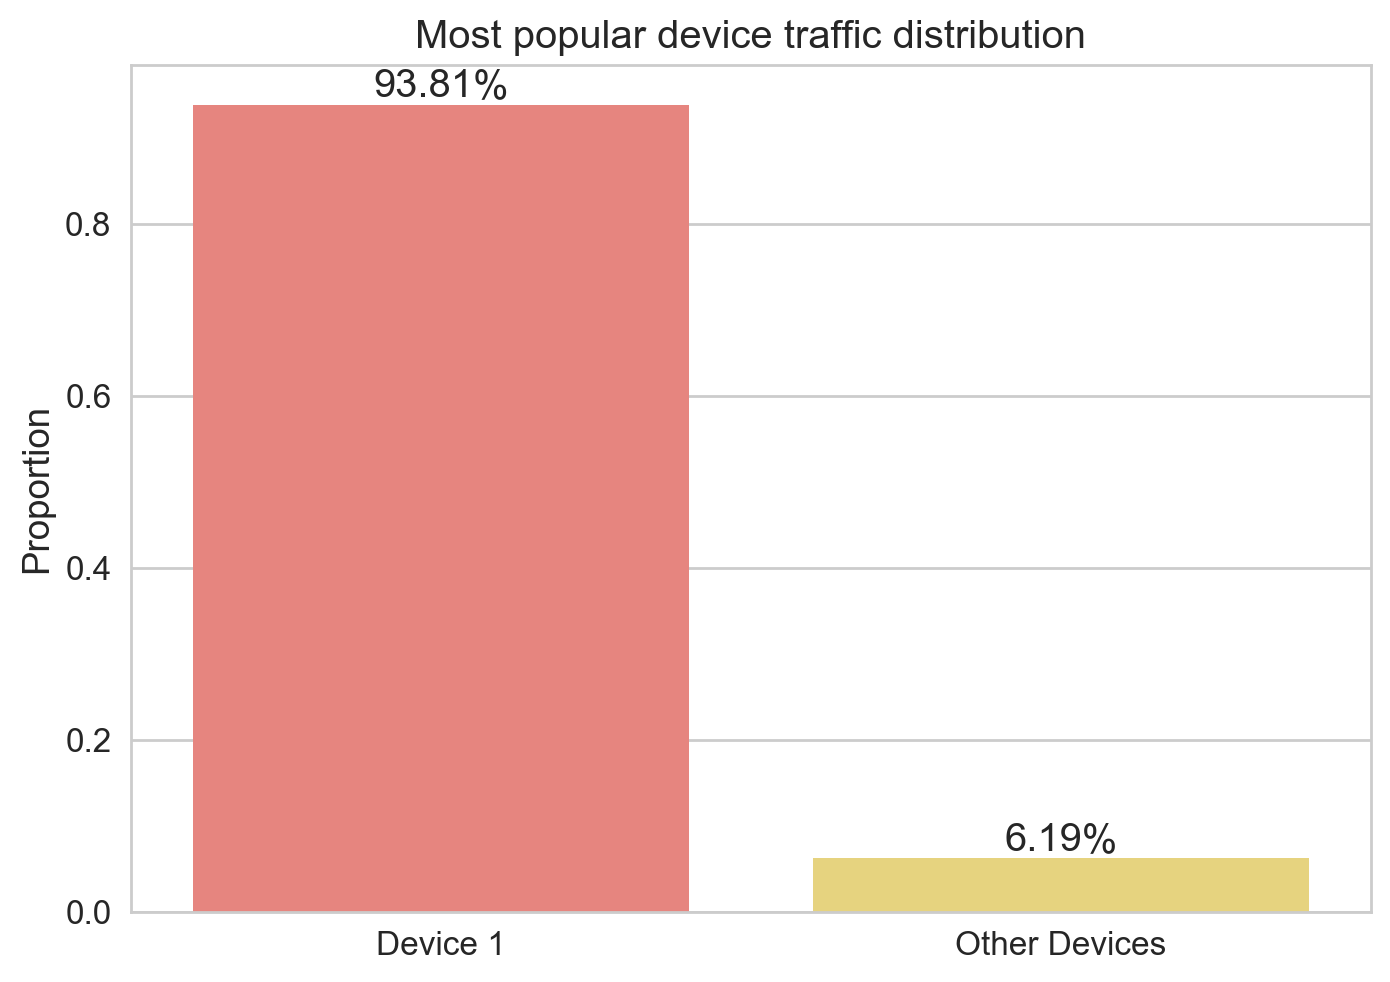

In [27]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
mean=9381146/merge.click_count.sum()
print(mean)

ax = sns.barplot(['Device 1', 'Other Devices'], [mean, 1-mean],palette=sns.hls_palette(8, l=.7, s=.9))
ax.set(ylabel='Proportion', title='Most popular device traffic distribution')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


Text(0.5,1,'Conversion Rates of 100 Most Popular Channel')

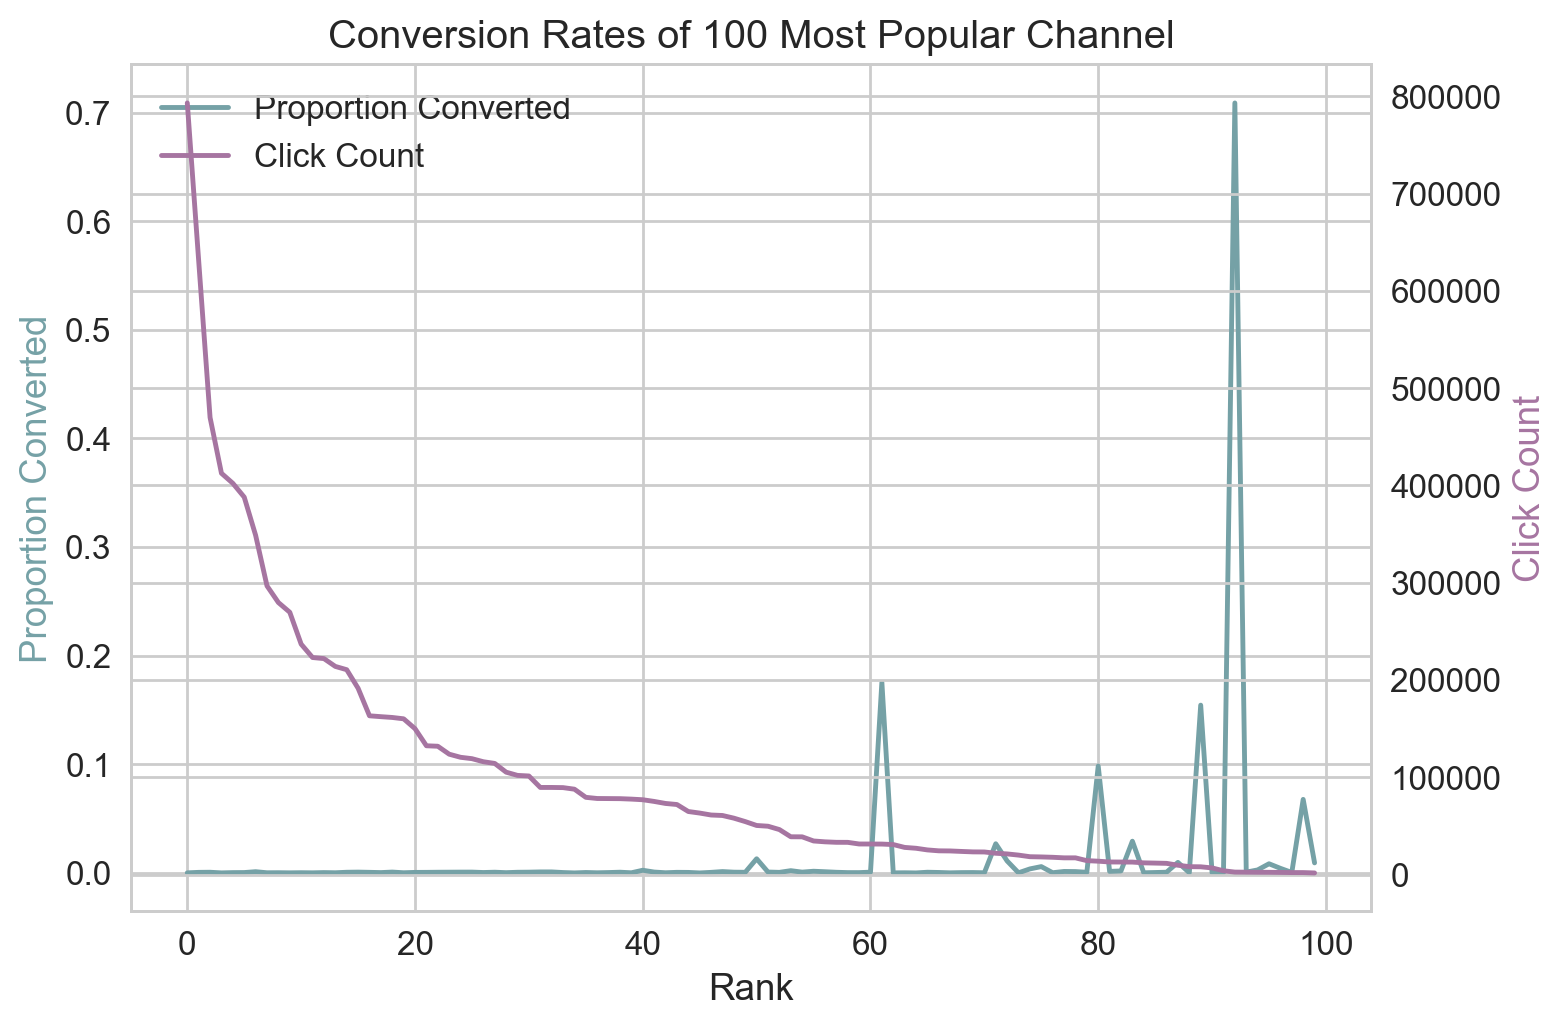

In [51]:
sns.set_style("whitegrid")
proportion = train[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

top=merge[0:100]
x=top['channel'].index
ycount=top['click_count']
yprop=top['prop_downloaded']

fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Rank")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, yprop, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')
plt.title('Conversion Rates of 100 Most Popular Channel')




There appear to be a few peaks for channels at reasonable click quantity, but overall the pattern holds same as for categories above.

In [41]:
from pandas.tools.plotting import scatter_matrix

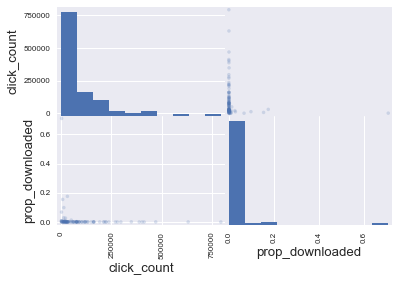

In [135]:
fig, ax = plt.subplots()
scatter_matrix(merge[0:100][['click_count', 'prop_downloaded']], alpha=0.2, diagonal='hist', ax=ax);

In [140]:
print(train.head())

       ip app device  os channel          click_time attributed_time  \
0   83230   3      1  13     379 2017-11-06 14:32:21             NaT   
1   17357   3      1  19     379 2017-11-06 14:33:34             NaT   
2   35810   3      1  13     379 2017-11-06 14:34:12             NaT   
3   45745  14      1  13     478 2017-11-06 14:34:52             NaT   
4  161007   3      1  13     379 2017-11-06 14:35:08             NaT   

   is_attributed  counts  
0              0    1327  
1              0    1057  
2              0     449  
3              0    9395  
4              0     184  


## Practice sequence

Round the click time down to an hour of the day to see if there are any hourly patterns.

For this part cannot use the first n rows from train data, as it's organized by time. To get a genral idea for the pattern, will use train data from the randomly sampled 100000 train set provided by organizers.

In [30]:
train_smp = pd.read_csv('train_sample.csv')

In [31]:
#convert click_time and attributed_time to time series
train_smp['click_time'] = pd.to_datetime(train_smp['click_time'])
train_smp['attributed_time'] = pd.to_datetime(train_smp['attributed_time'])

In [32]:
train_smp[train_smp['ip']==83230 ]

ip  app  device  os  channel          click_time attributed_time  \
8621   83230   18       1  30      107 2017-11-09 00:39:36             NaT   
10473  83230    9       1  25      215 2017-11-06 16:20:24             NaT   
23901  83230    3       1  19      173 2017-11-09 09:58:39             NaT   
26258  83230    9       1  31      334 2017-11-09 08:17:21             NaT   
40550  83230   12       1  13      178 2017-11-07 03:32:59             NaT   
56625  83230    3       1  19      280 2017-11-08 09:40:33             NaT   
70005  83230   15       1   1      315 2017-11-07 11:23:13             NaT   
70053  83230   12       1  53      265 2017-11-08 01:04:46             NaT   
73251  83230   18       1  13      107 2017-11-09 15:26:21             NaT   
75659  83230    6       1  13      459 2017-11-06 19:59:56             NaT   
90209  83230   18       1  13      107 2017-11-08 00:45:59             NaT   

       is_attributed  
8621               0  
10473              0  
23901              0  
26258              0  
40550              0  
56625              0  
70005              0  
70053              0  
73251              0  
75659              0  
90209              0

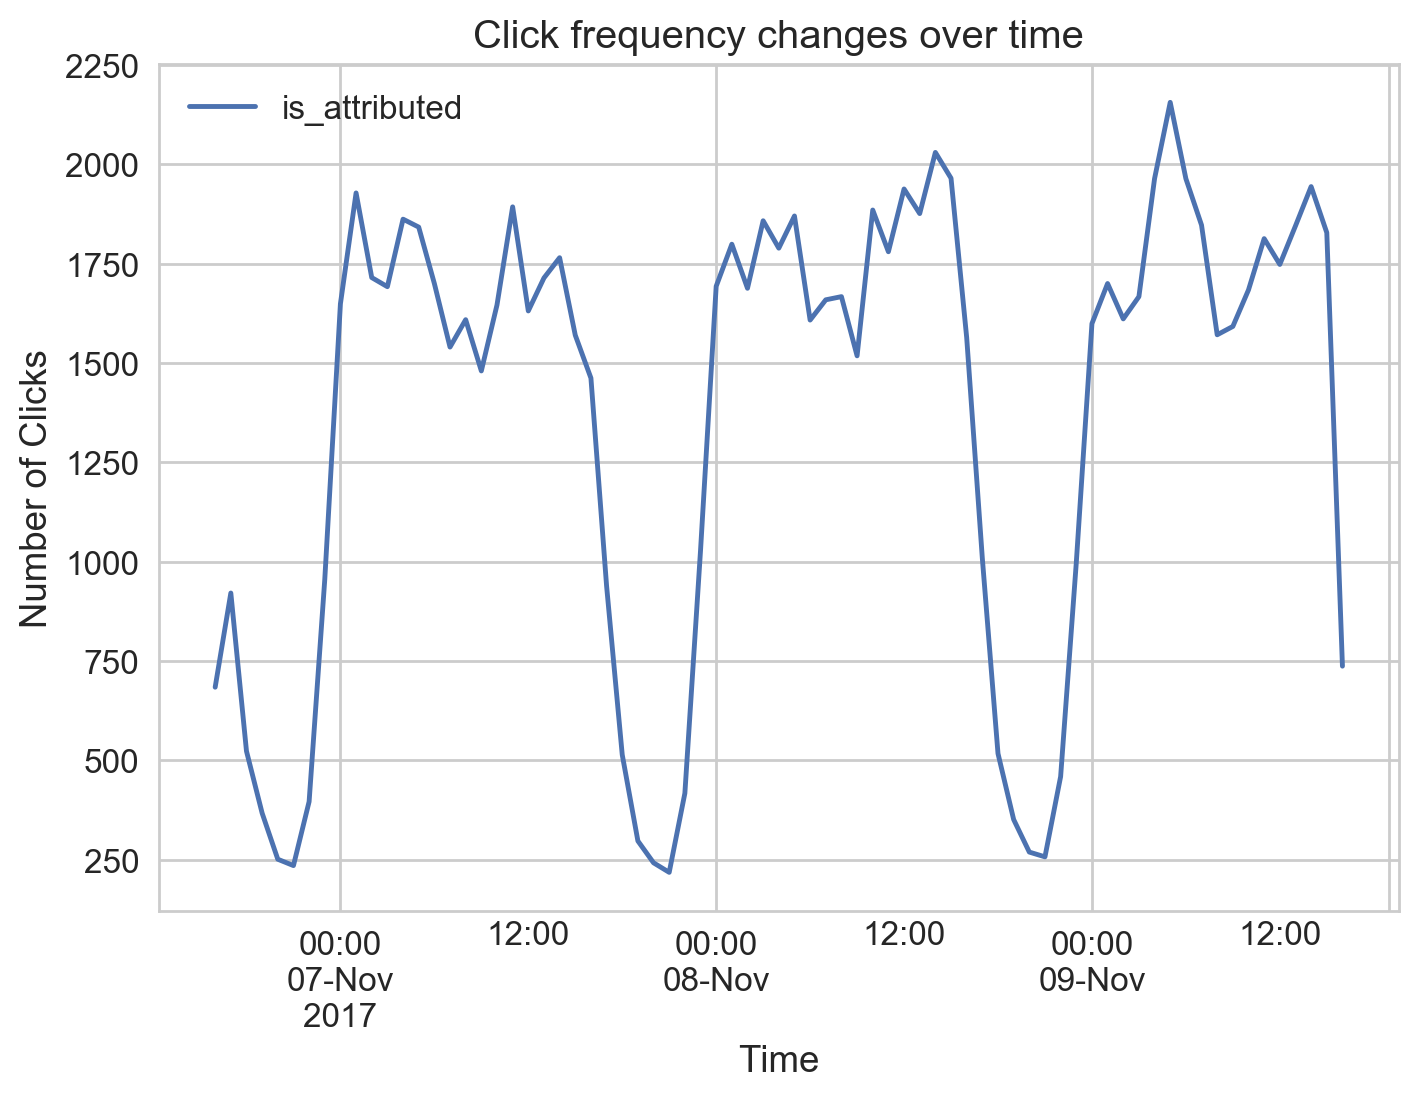

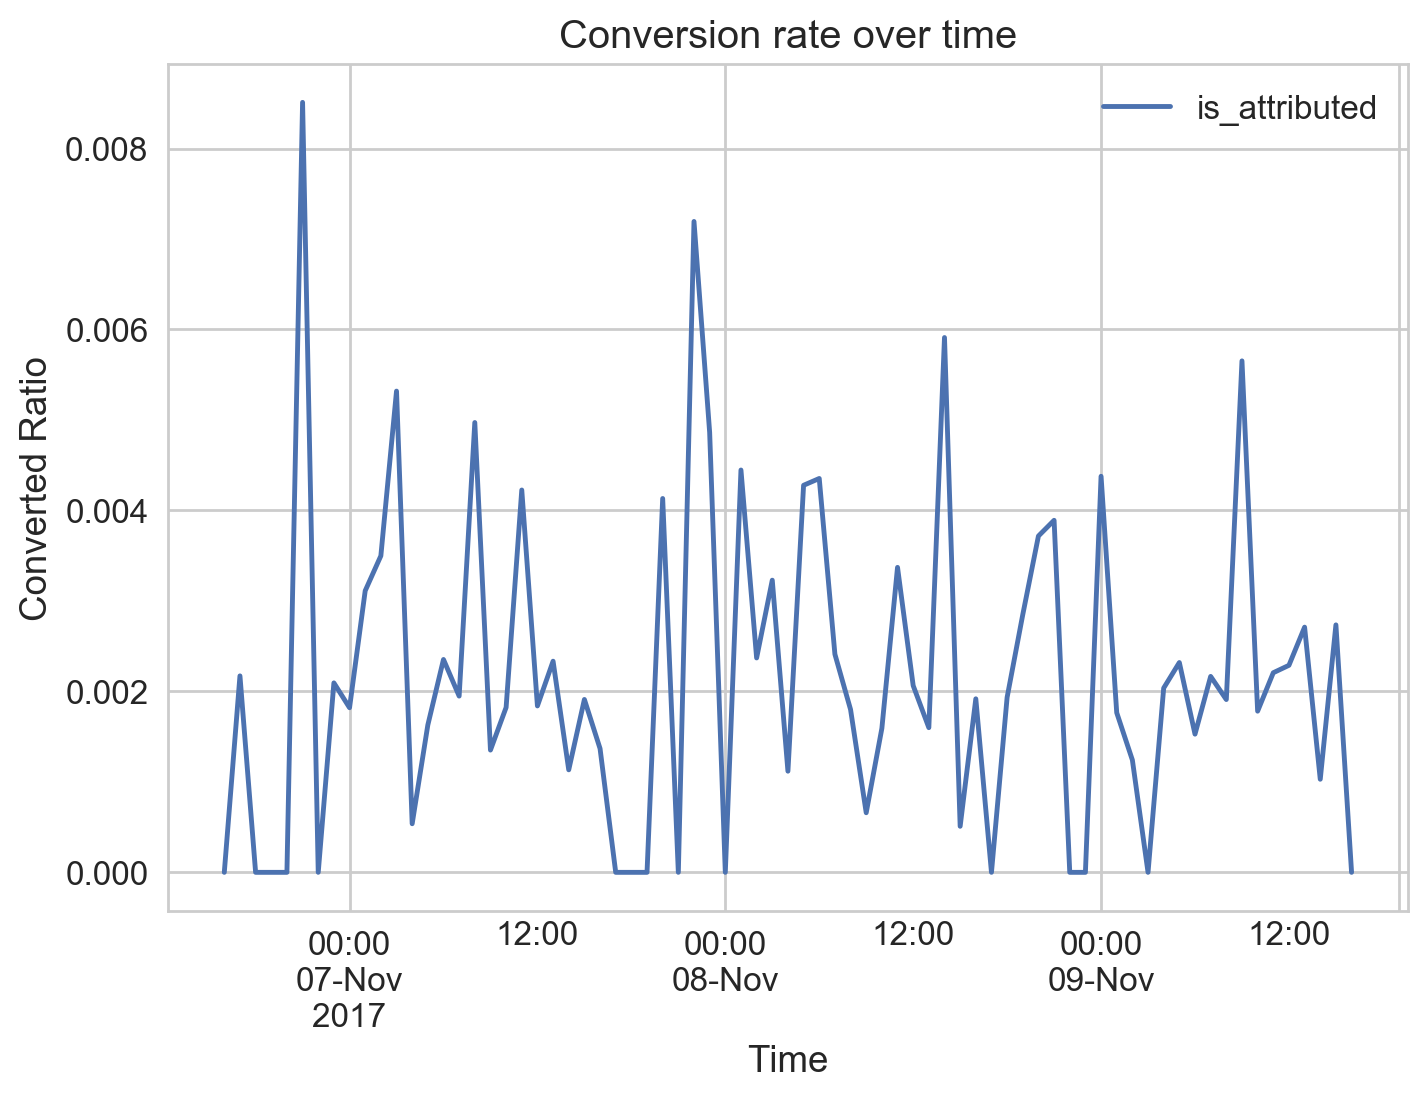

In [89]:
#round the time to nearest hour
train_smp['click_rnd']=train_smp['click_time'].dt.round('H')  

#check for hourly patterns
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('Click frequency changes over time');
plt.ylabel('Number of Clicks');
plt.xlabel('Time');

train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('Conversion rate over time');
plt.ylabel('Converted Ratio');
plt.xlabel('Time');

In [38]:
train_smp['day'] = train_smp['click_time'].dt.day.astype('uint8')
train_smp['hour'] = train_smp['click_time'].dt.hour.astype('uint8')
train_smp['minute'] = train_smp['click_time'].dt.minute.astype('uint8')
train_smp['second'] = train_smp['click_time'].dt.second.astype('uint8')


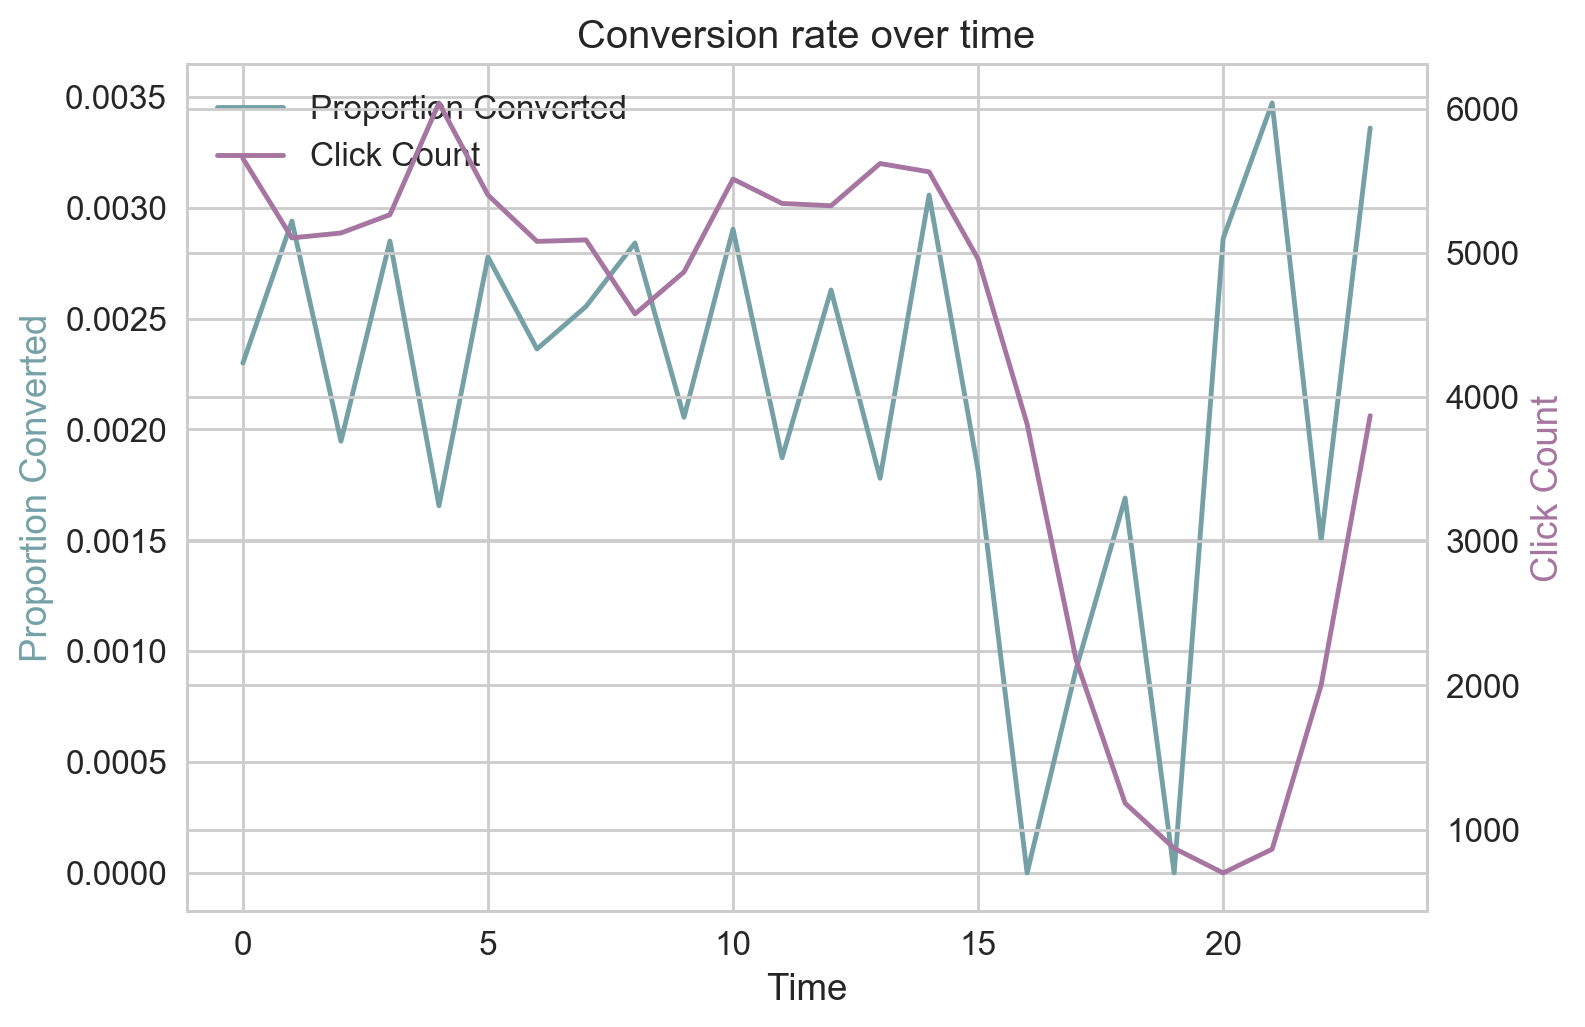

In [69]:
group = train_smp[['hour','is_attributed']].groupby(['hour'], as_index=False).mean()
x = group['hour']
ymean = group['is_attributed']
group = train_smp[['hour','is_attributed']].groupby(['hour'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'
host.legend(handles=lns, loc='best')
plt.title('Conversion rate over time');
p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')


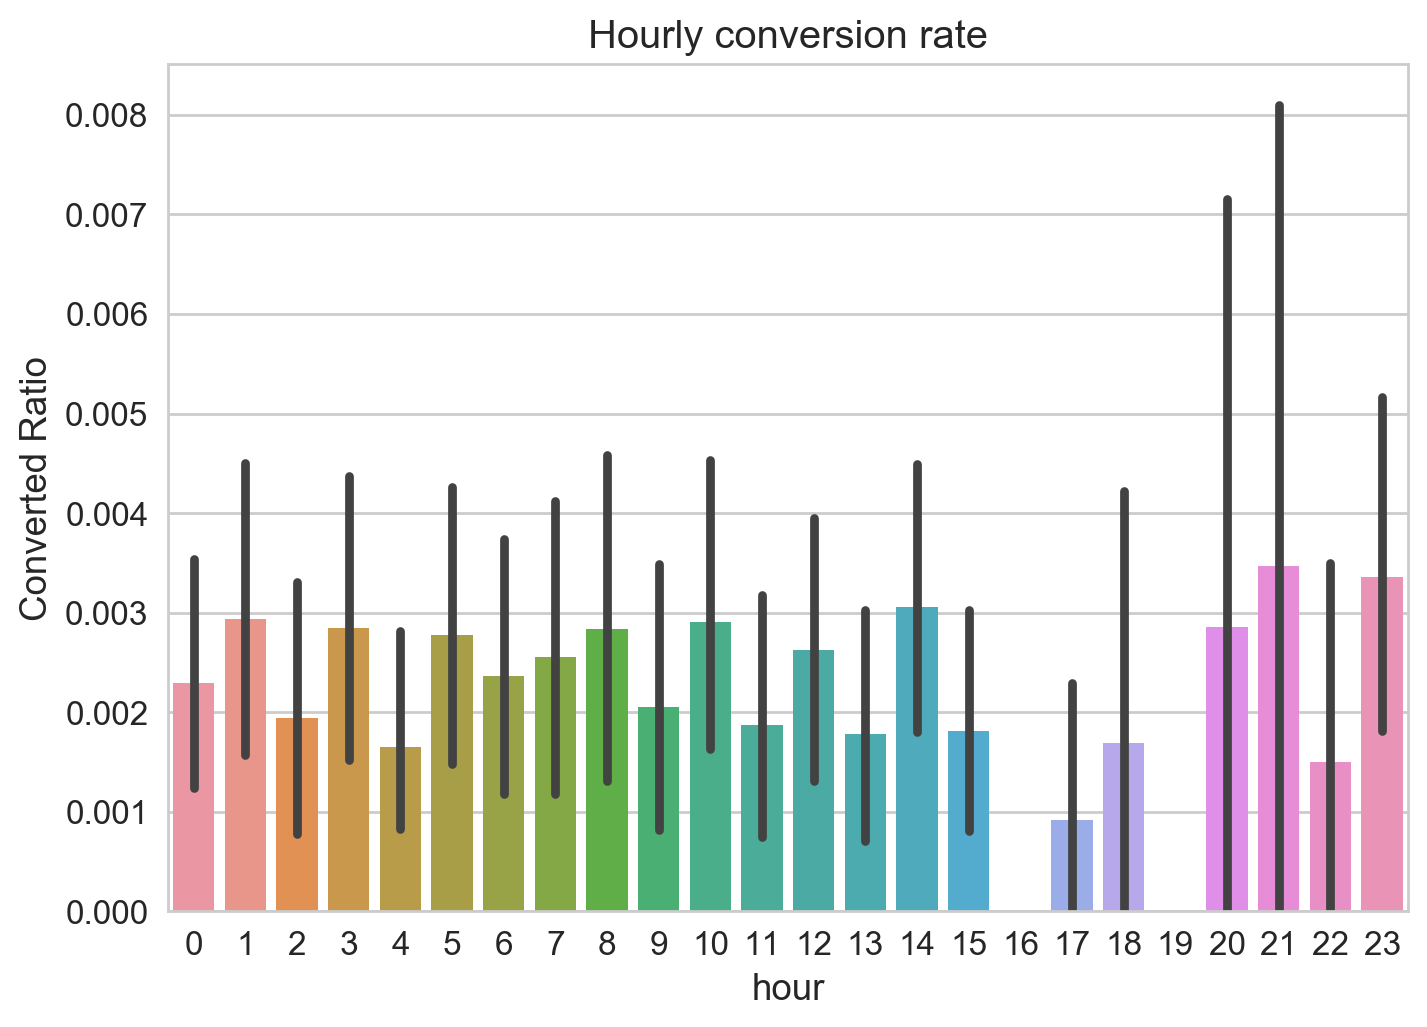

In [40]:
sns.barplot('hour', 'is_attributed', data=train_smp)
plt.title('Hourly conversion rate');
plt.ylabel('Converted Ratio');

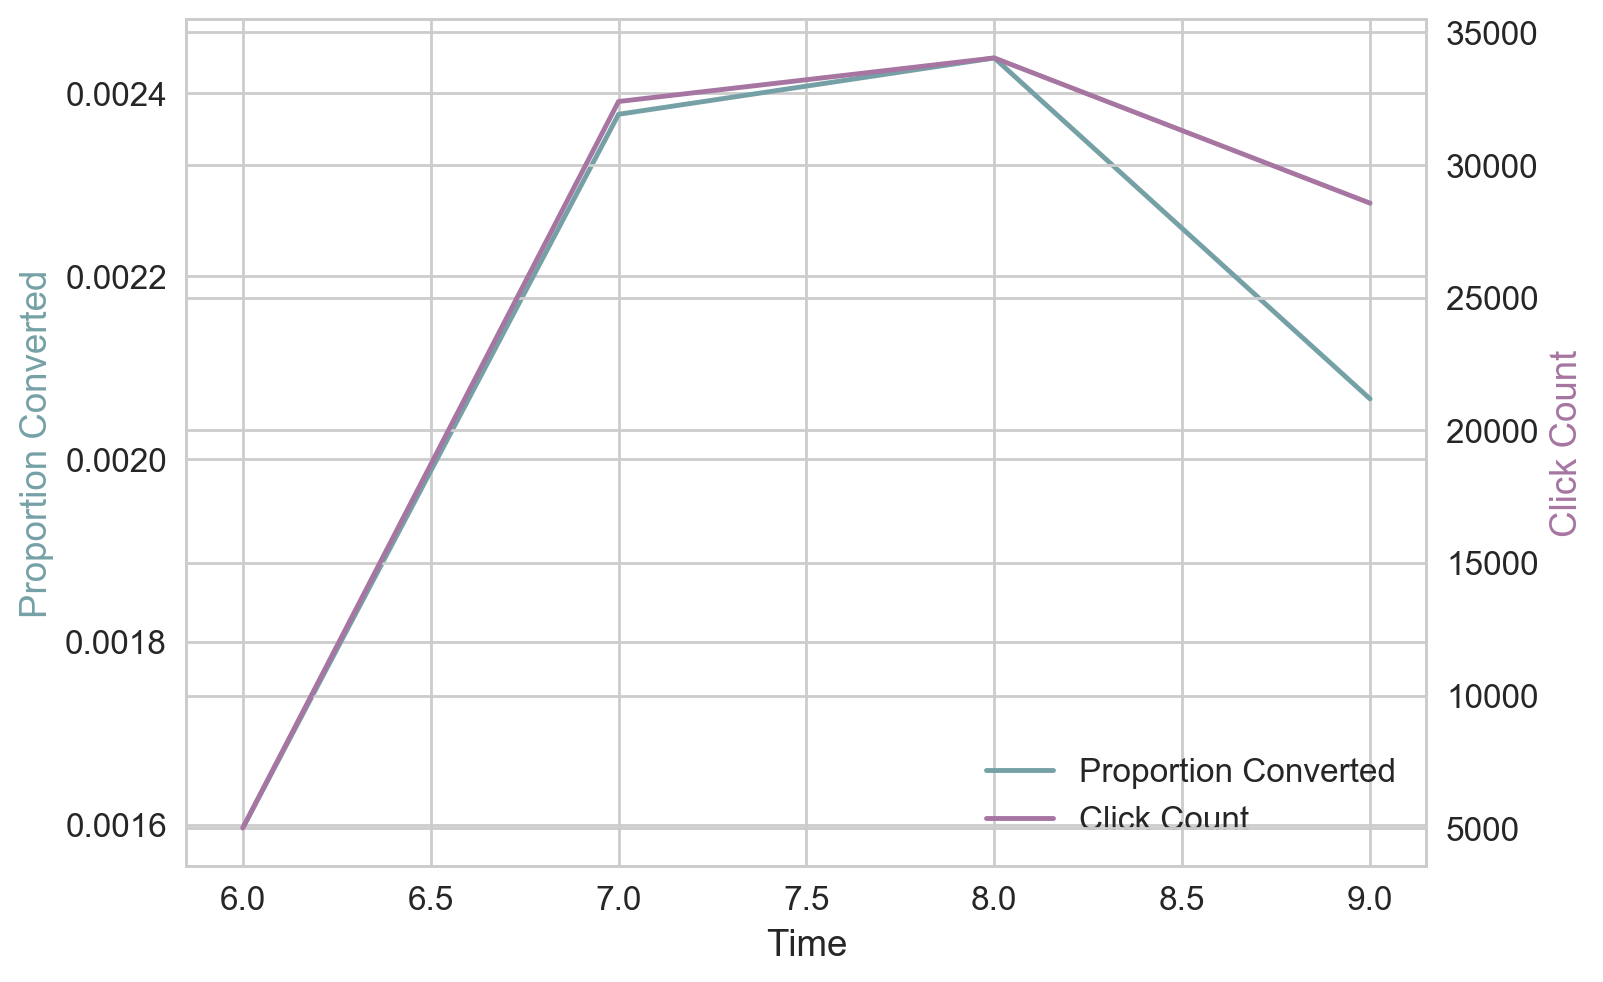

In [60]:
group = train_smp[['day','is_attributed']].groupby(['day'], as_index=False).mean()
x = group['day']
ymean = group['is_attributed']
group = train_smp[['day','is_attributed']].groupby(['day'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

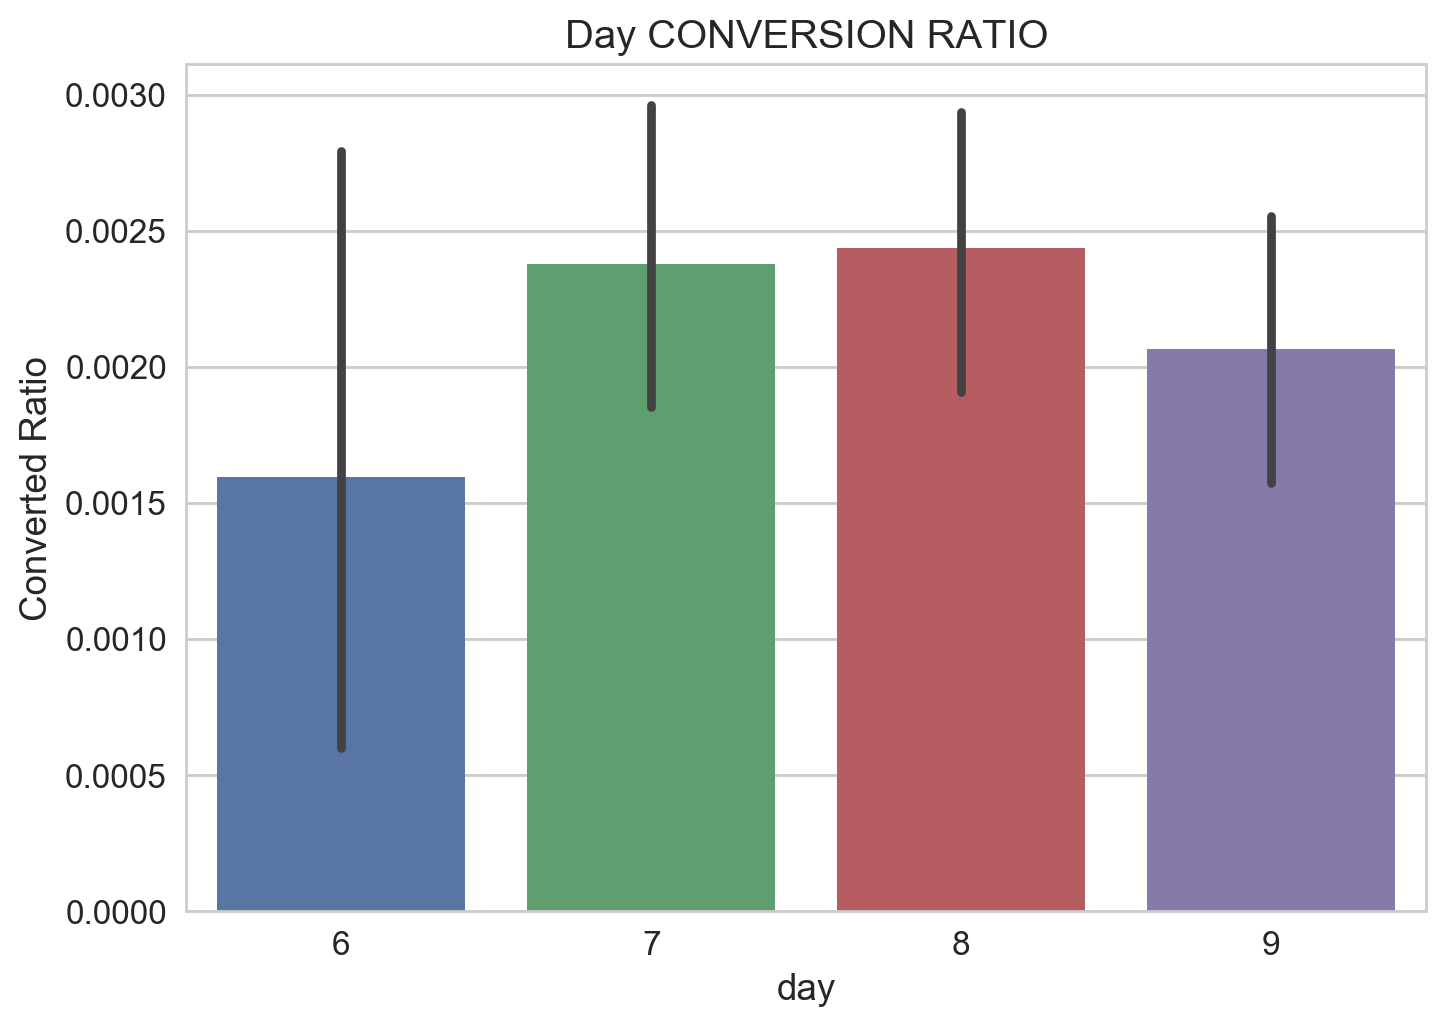

In [69]:
sns.barplot('day', 'is_attributed', data=train_smp)
plt.title('day conversion rate');
plt.ylabel('Converted Ratio');

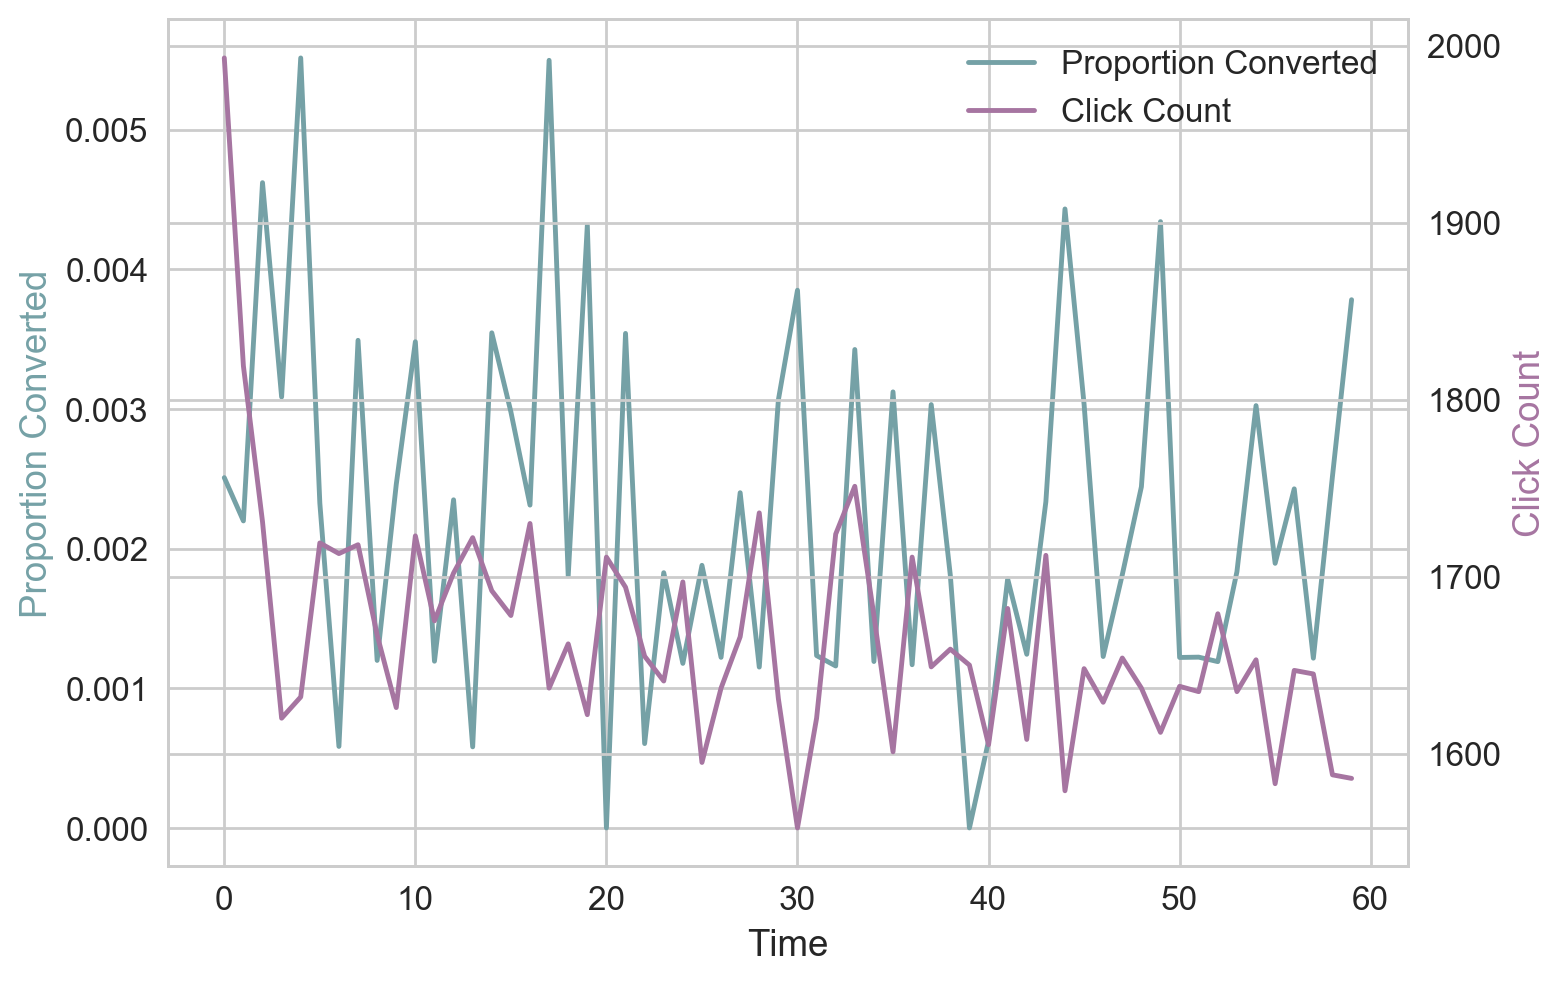

In [61]:
group = train_smp[['minute','is_attributed']].groupby(['minute'], as_index=False).mean()
x = group['minute']
ymean = group['is_attributed']
group = train_smp[['minute','is_attributed']].groupby(['minute'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

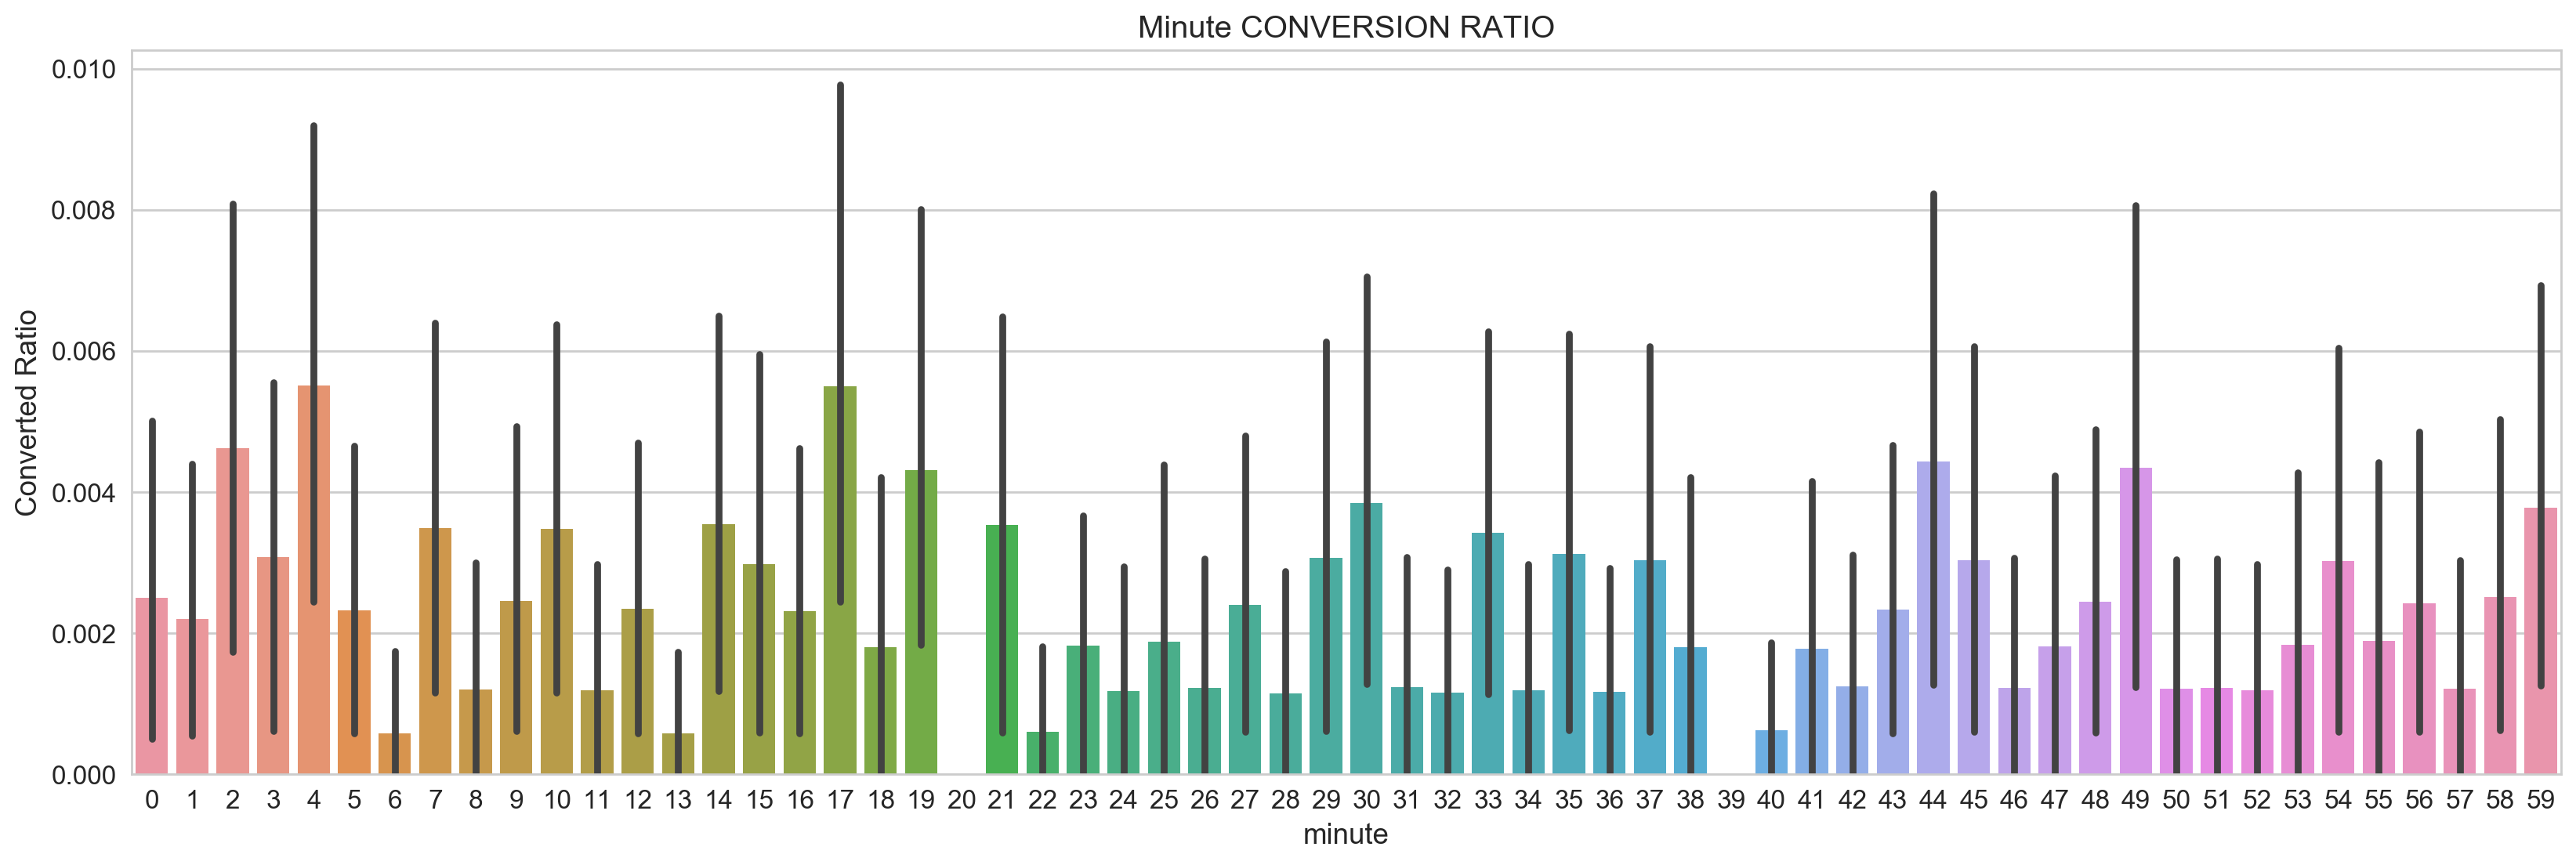

In [75]:
plt.figure(figsize=(20, 6))
sns.barplot('minute', 'is_attributed', data=train_smp)
plt.title('Minute CONVERSION RATIO');
plt.ylabel('Converted Ratio');

In [37]:
train= pd.read_csv('final_feature_train.csv',parse_dates=['click_time'])

Text(0.5,1,'The relationship between the number of times the user clicked on the ad and the conversion rate')

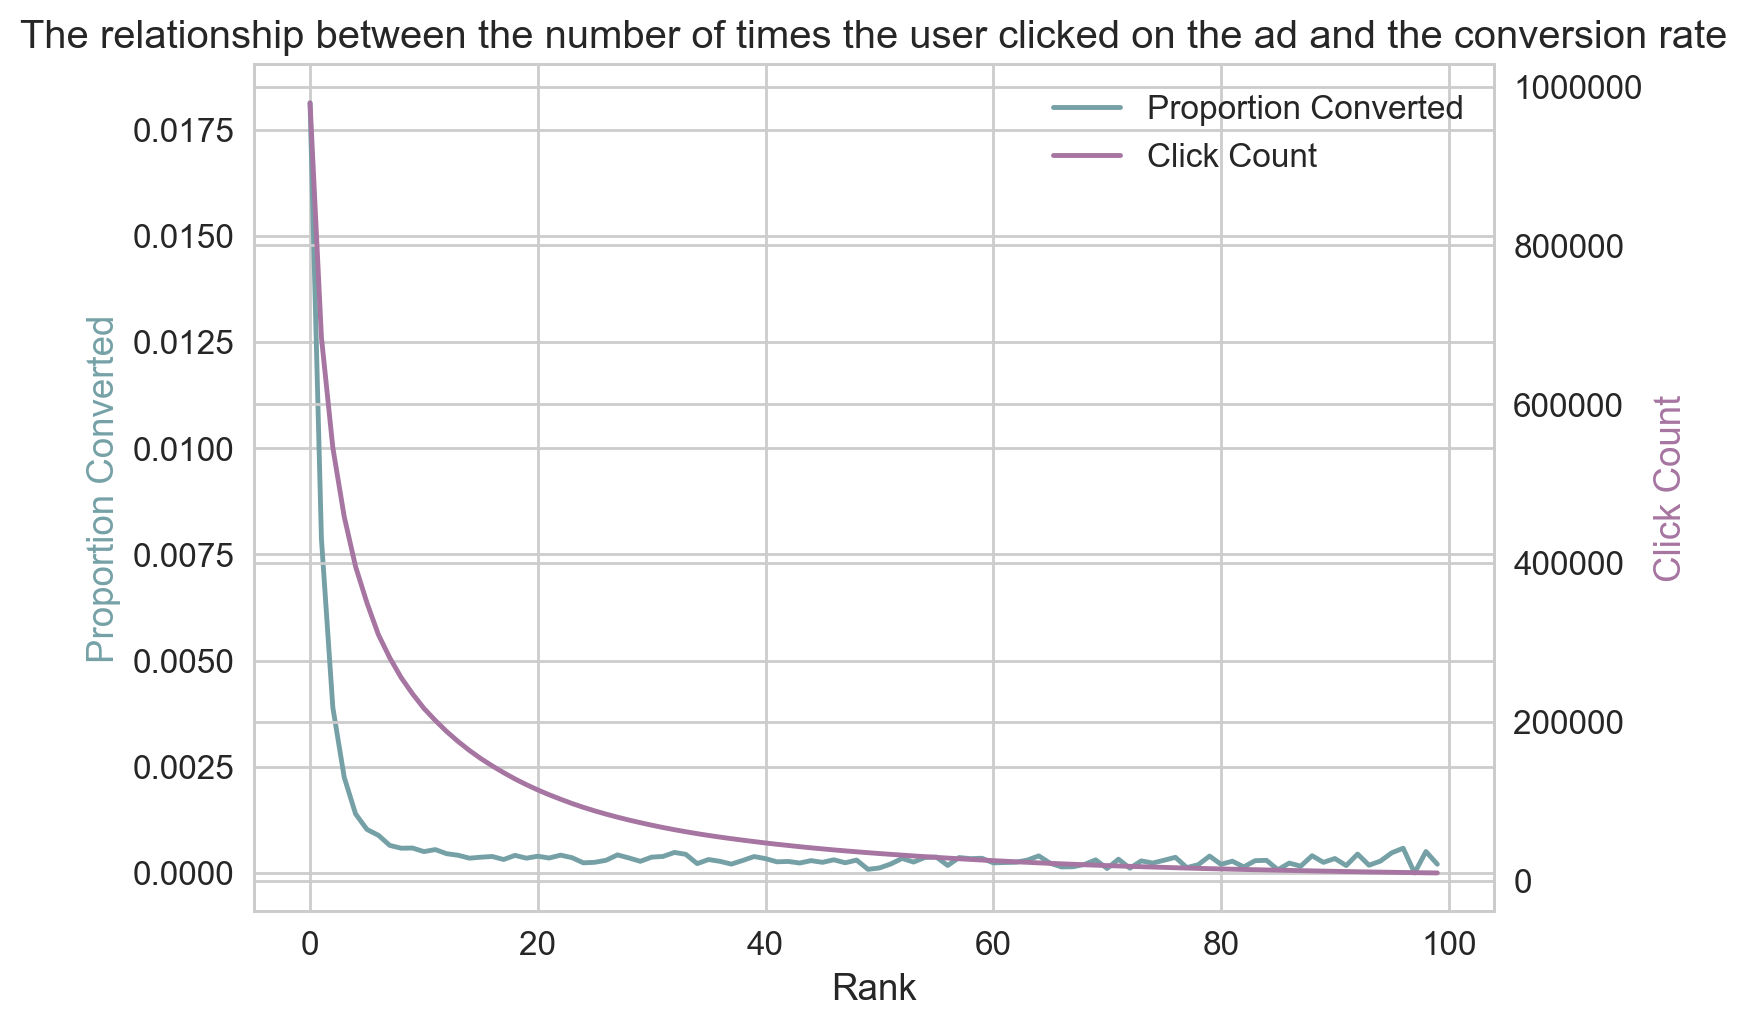

In [41]:
proportion = train[['prev_app_clicks', 'is_attributed']].groupby('prev_app_clicks', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['prev_app_clicks', 'is_attributed']].groupby('prev_app_clicks', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='prev_app_clicks', how='left')
merge.columns = ['prev_app_clicks', 'click_count', 'prop_downloaded']

top=merge[0:100]
x=top['prev_app_clicks'].index
ycount=top['click_count']
yprop=top['prop_downloaded']

fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Rank")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, yprop, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')
plt.title('The relationship between the number of times the user clicked on the ad and the conversion rate')

Text(0.5,1,'The relationship between the number of times the user clicked on the ad and the conversion rate')

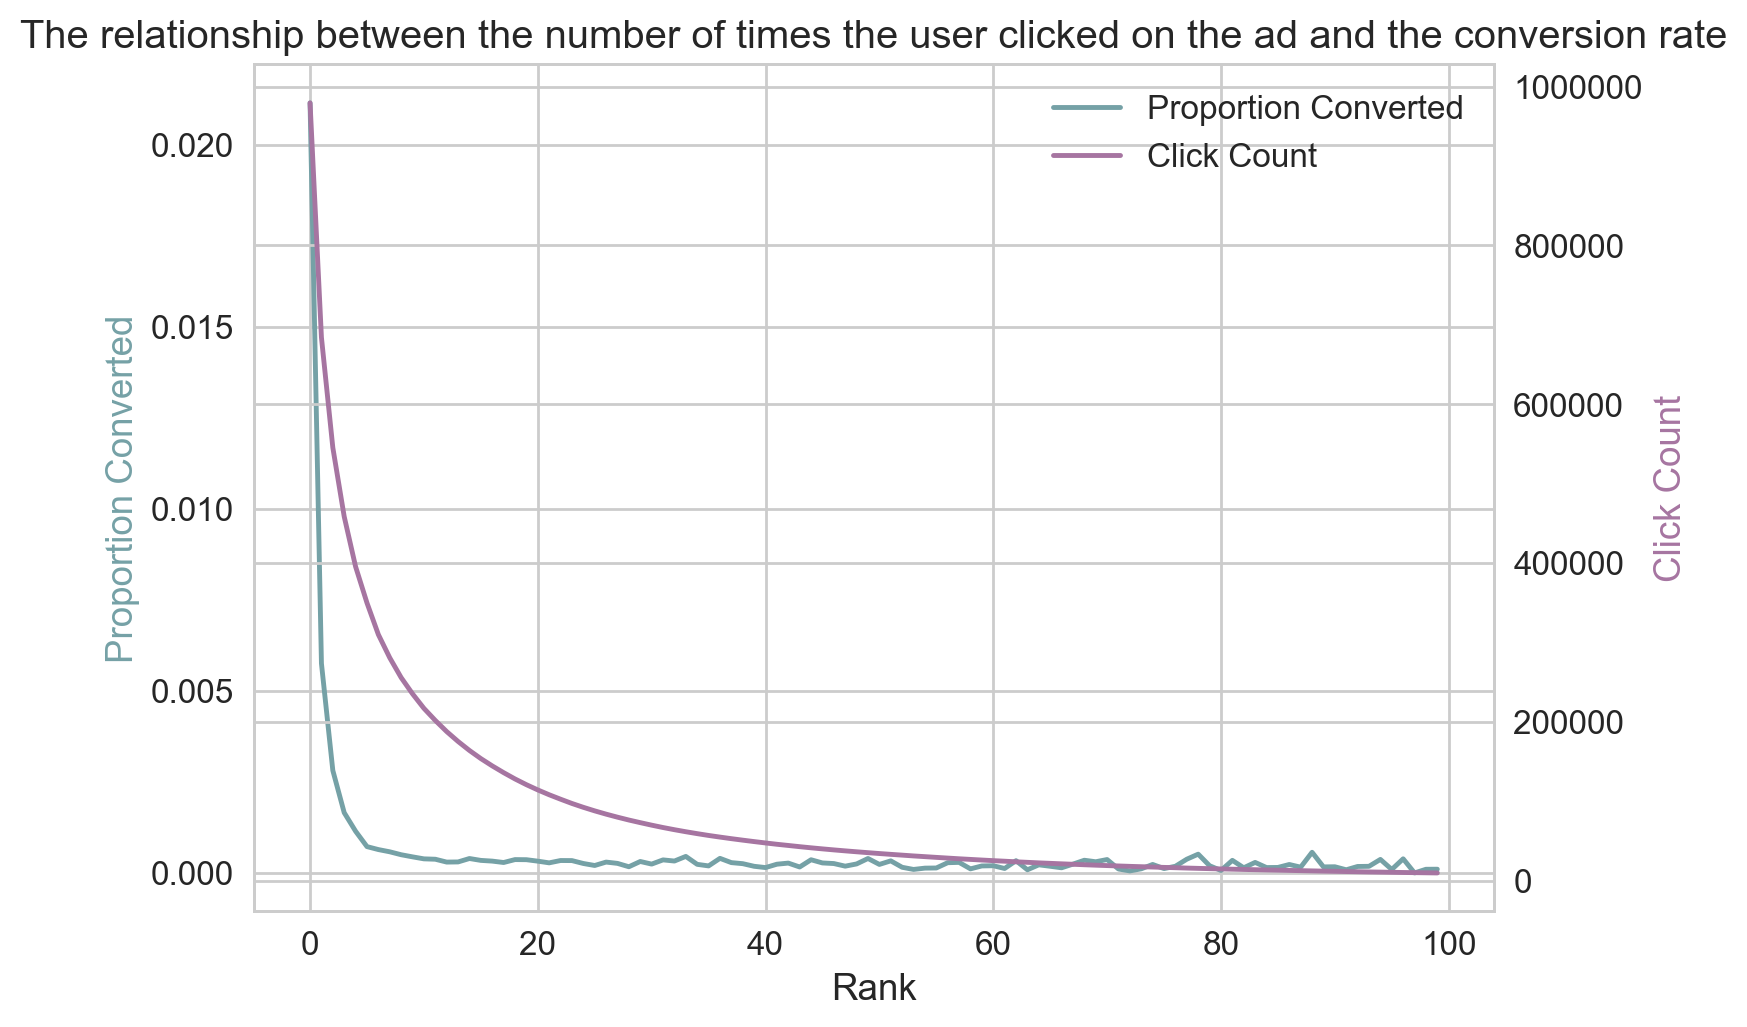

In [42]:
proportion = train[['future_app_clicks', 'is_attributed']].groupby('future_app_clicks', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['future_app_clicks', 'is_attributed']].groupby('future_app_clicks', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='future_app_clicks', how='left')
merge.columns = ['future_app_clicks', 'click_count', 'prop_downloaded']

top=merge[0:100]
x=top['future_app_clicks'].index
ycount=top['click_count']
yprop=top['prop_downloaded']

fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Rank")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, yprop, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')
plt.title('The relationship between the number of times the user clicked on the ad and the conversion rate')

In [61]:
# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

In [62]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
   
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

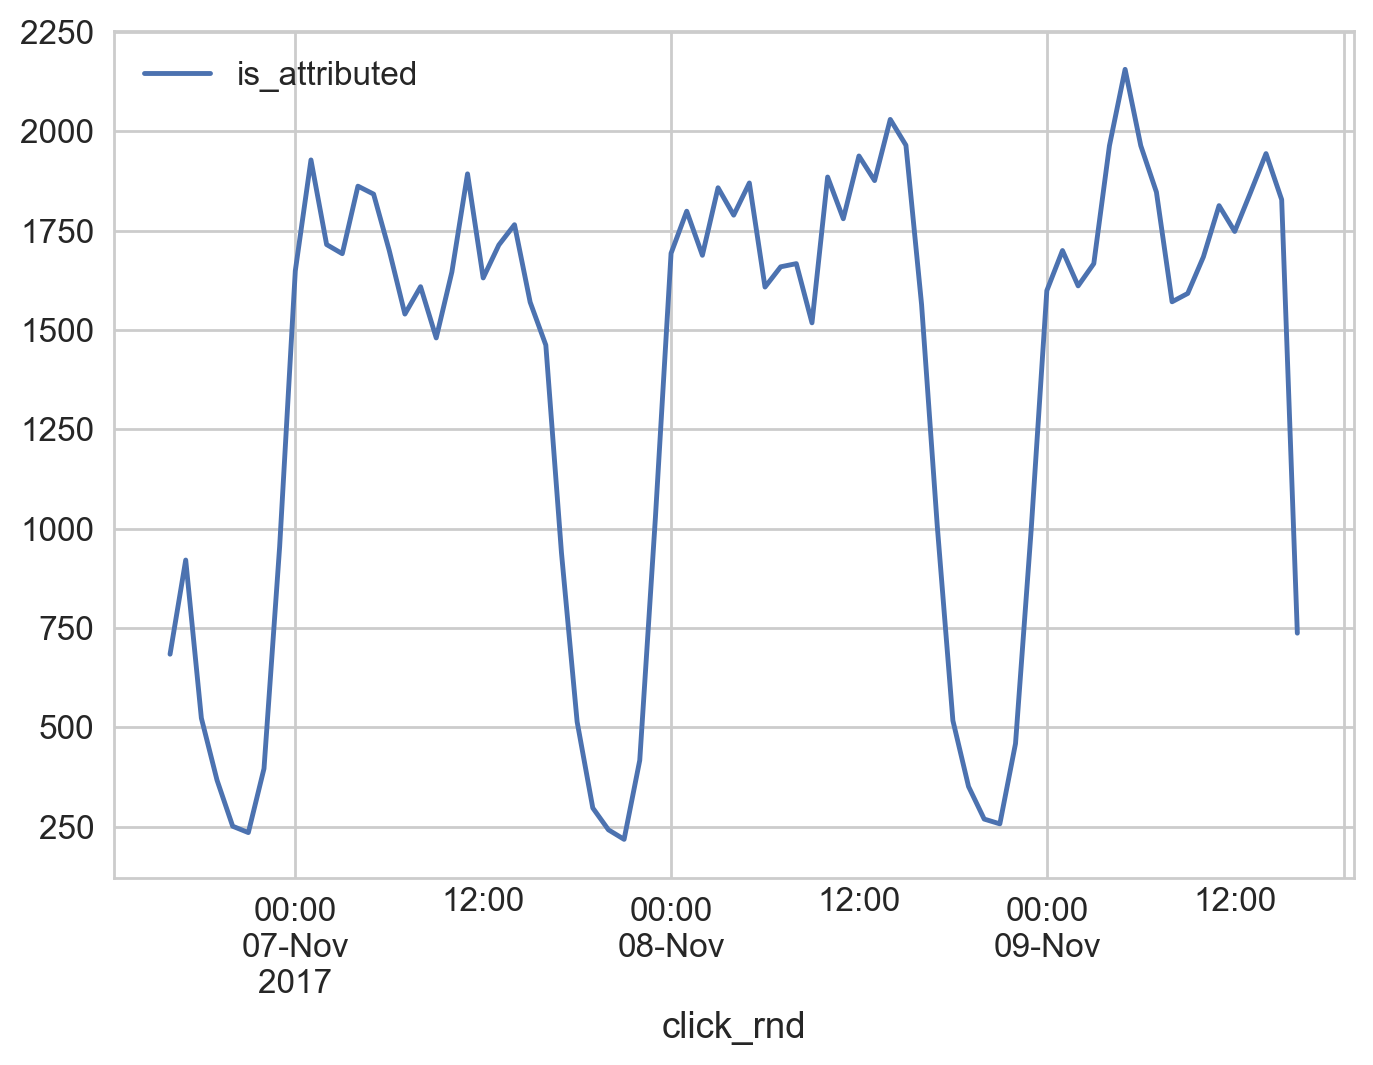

In [85]:
train_smp['click_rnd']=train_smp['click_time'].dt.round('H') 
#check for hourly patterns
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()

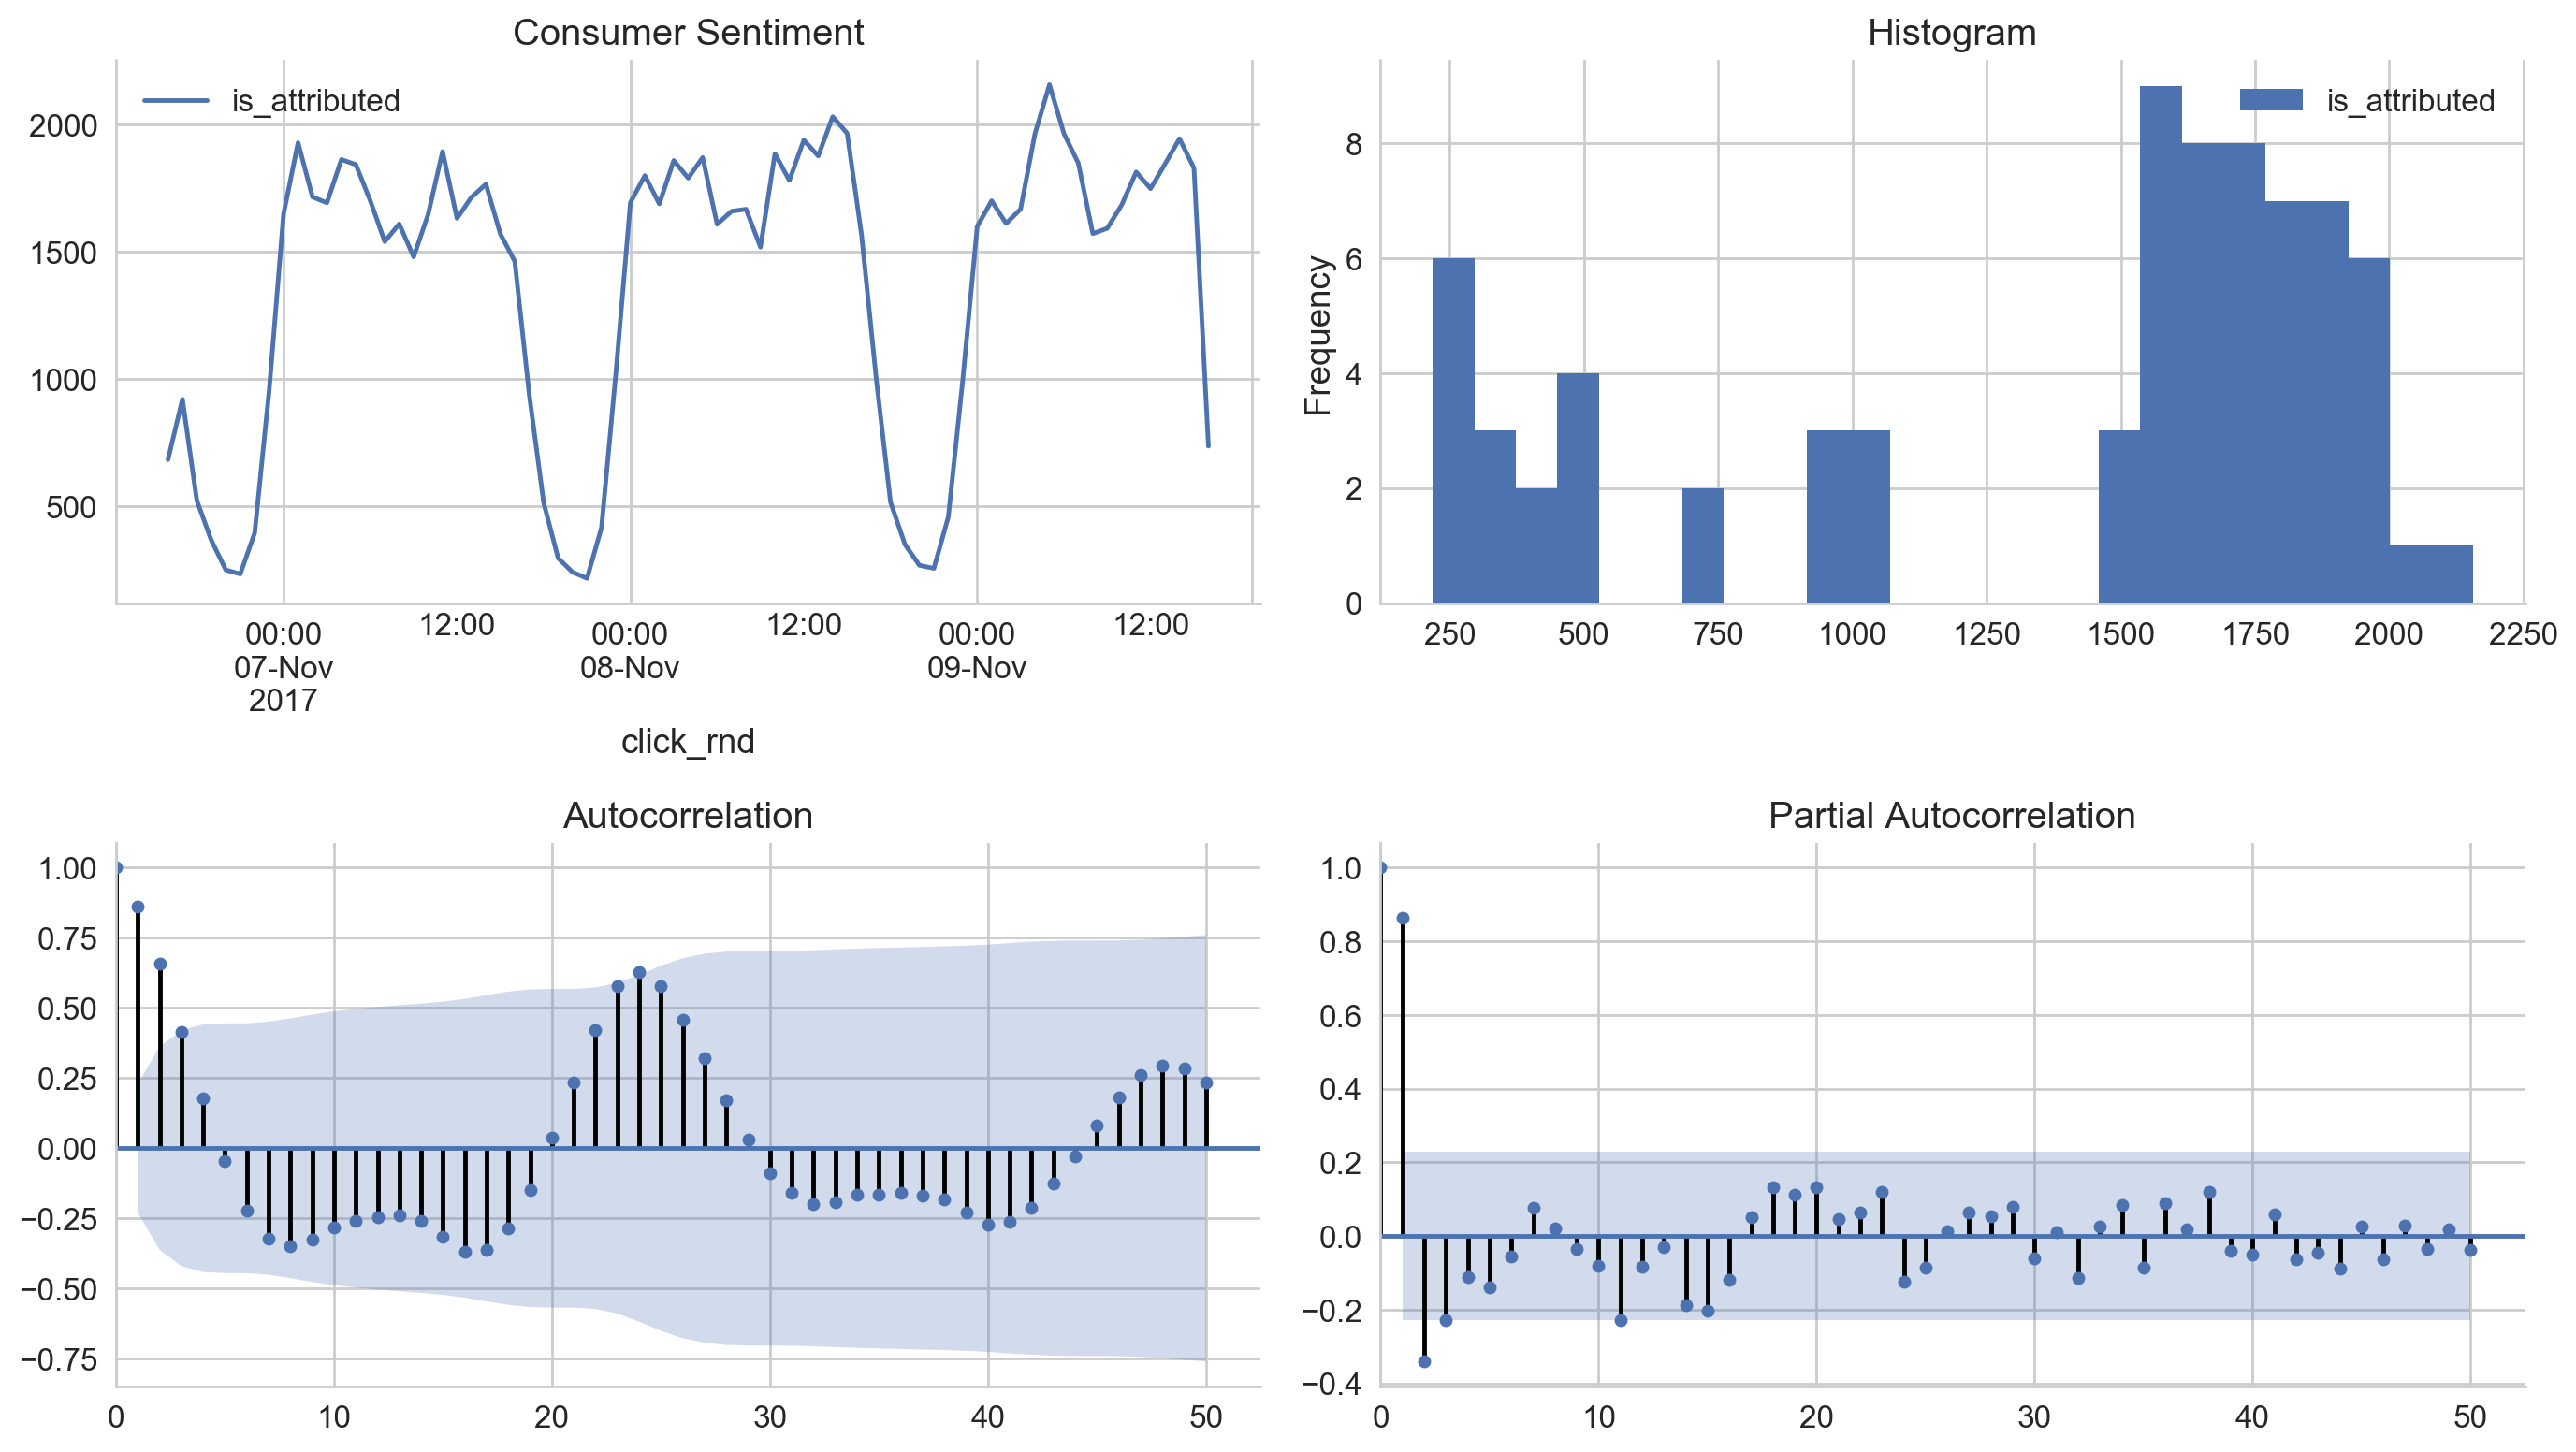

In [87]:
tsplot(train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count(), title='Consumer Sentiment', lags=50);

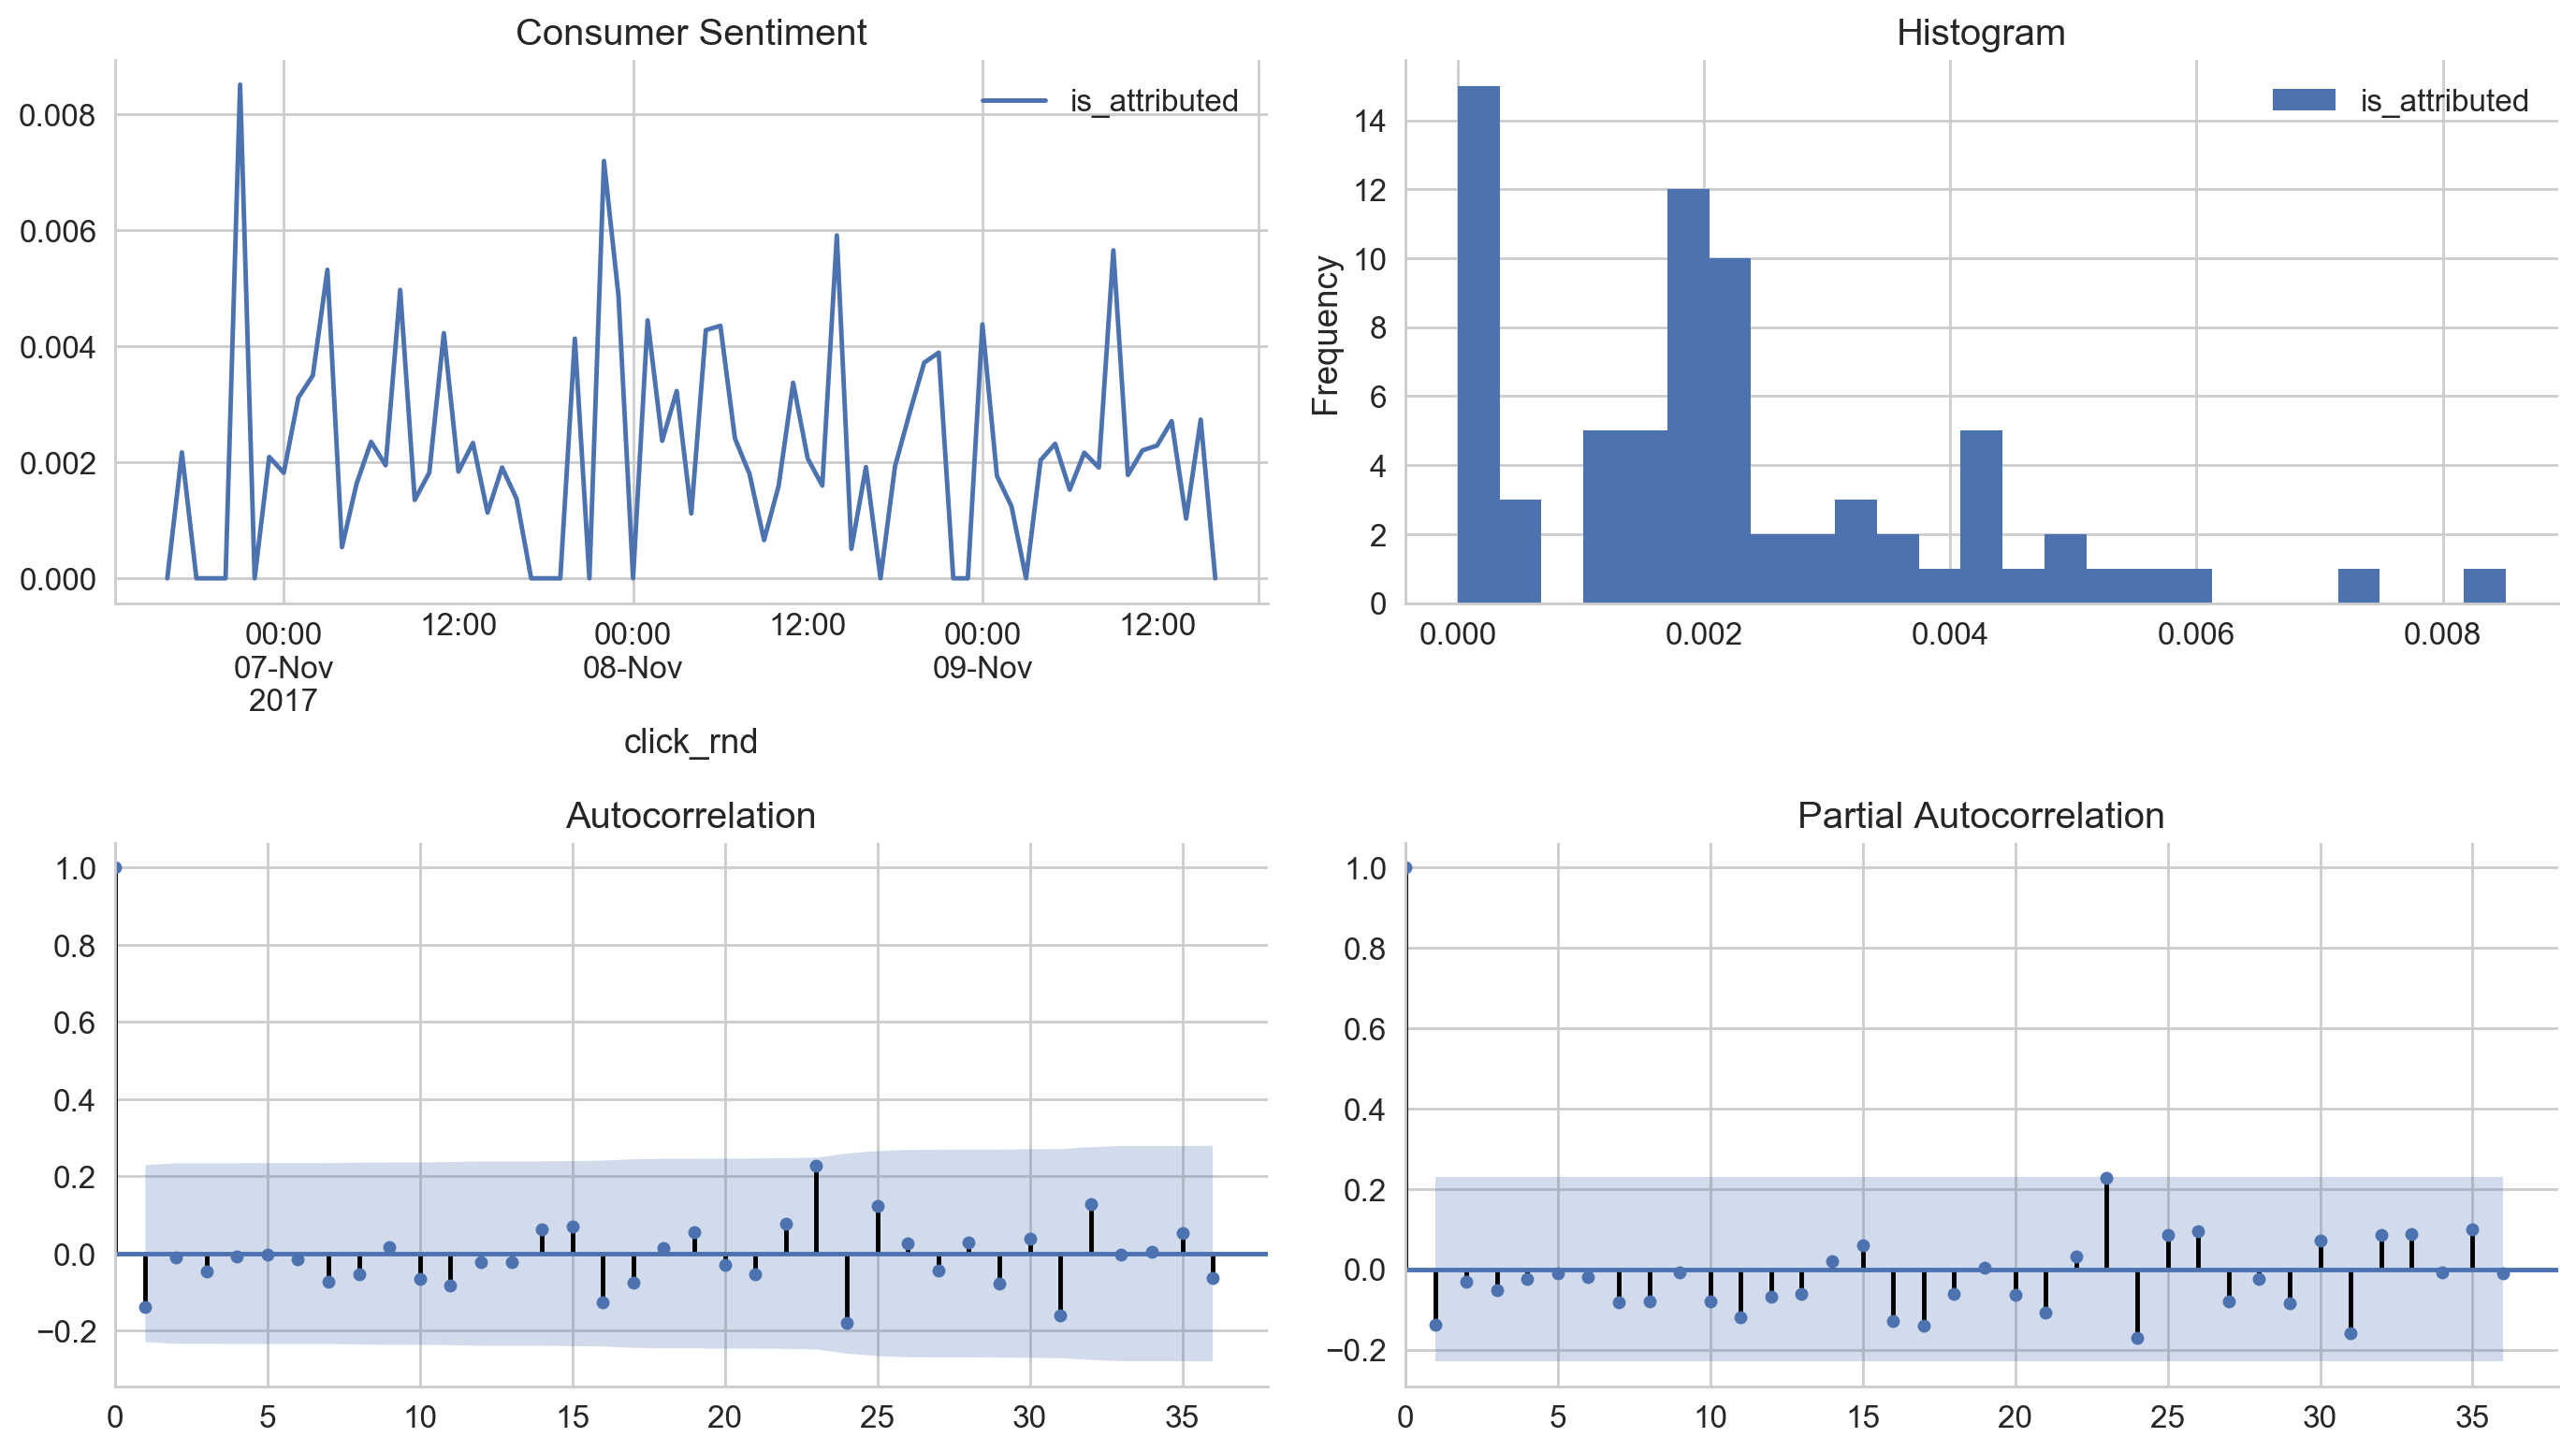

In [78]:
tsplot(train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean(), title='Consumer Sentiment', lags=36);

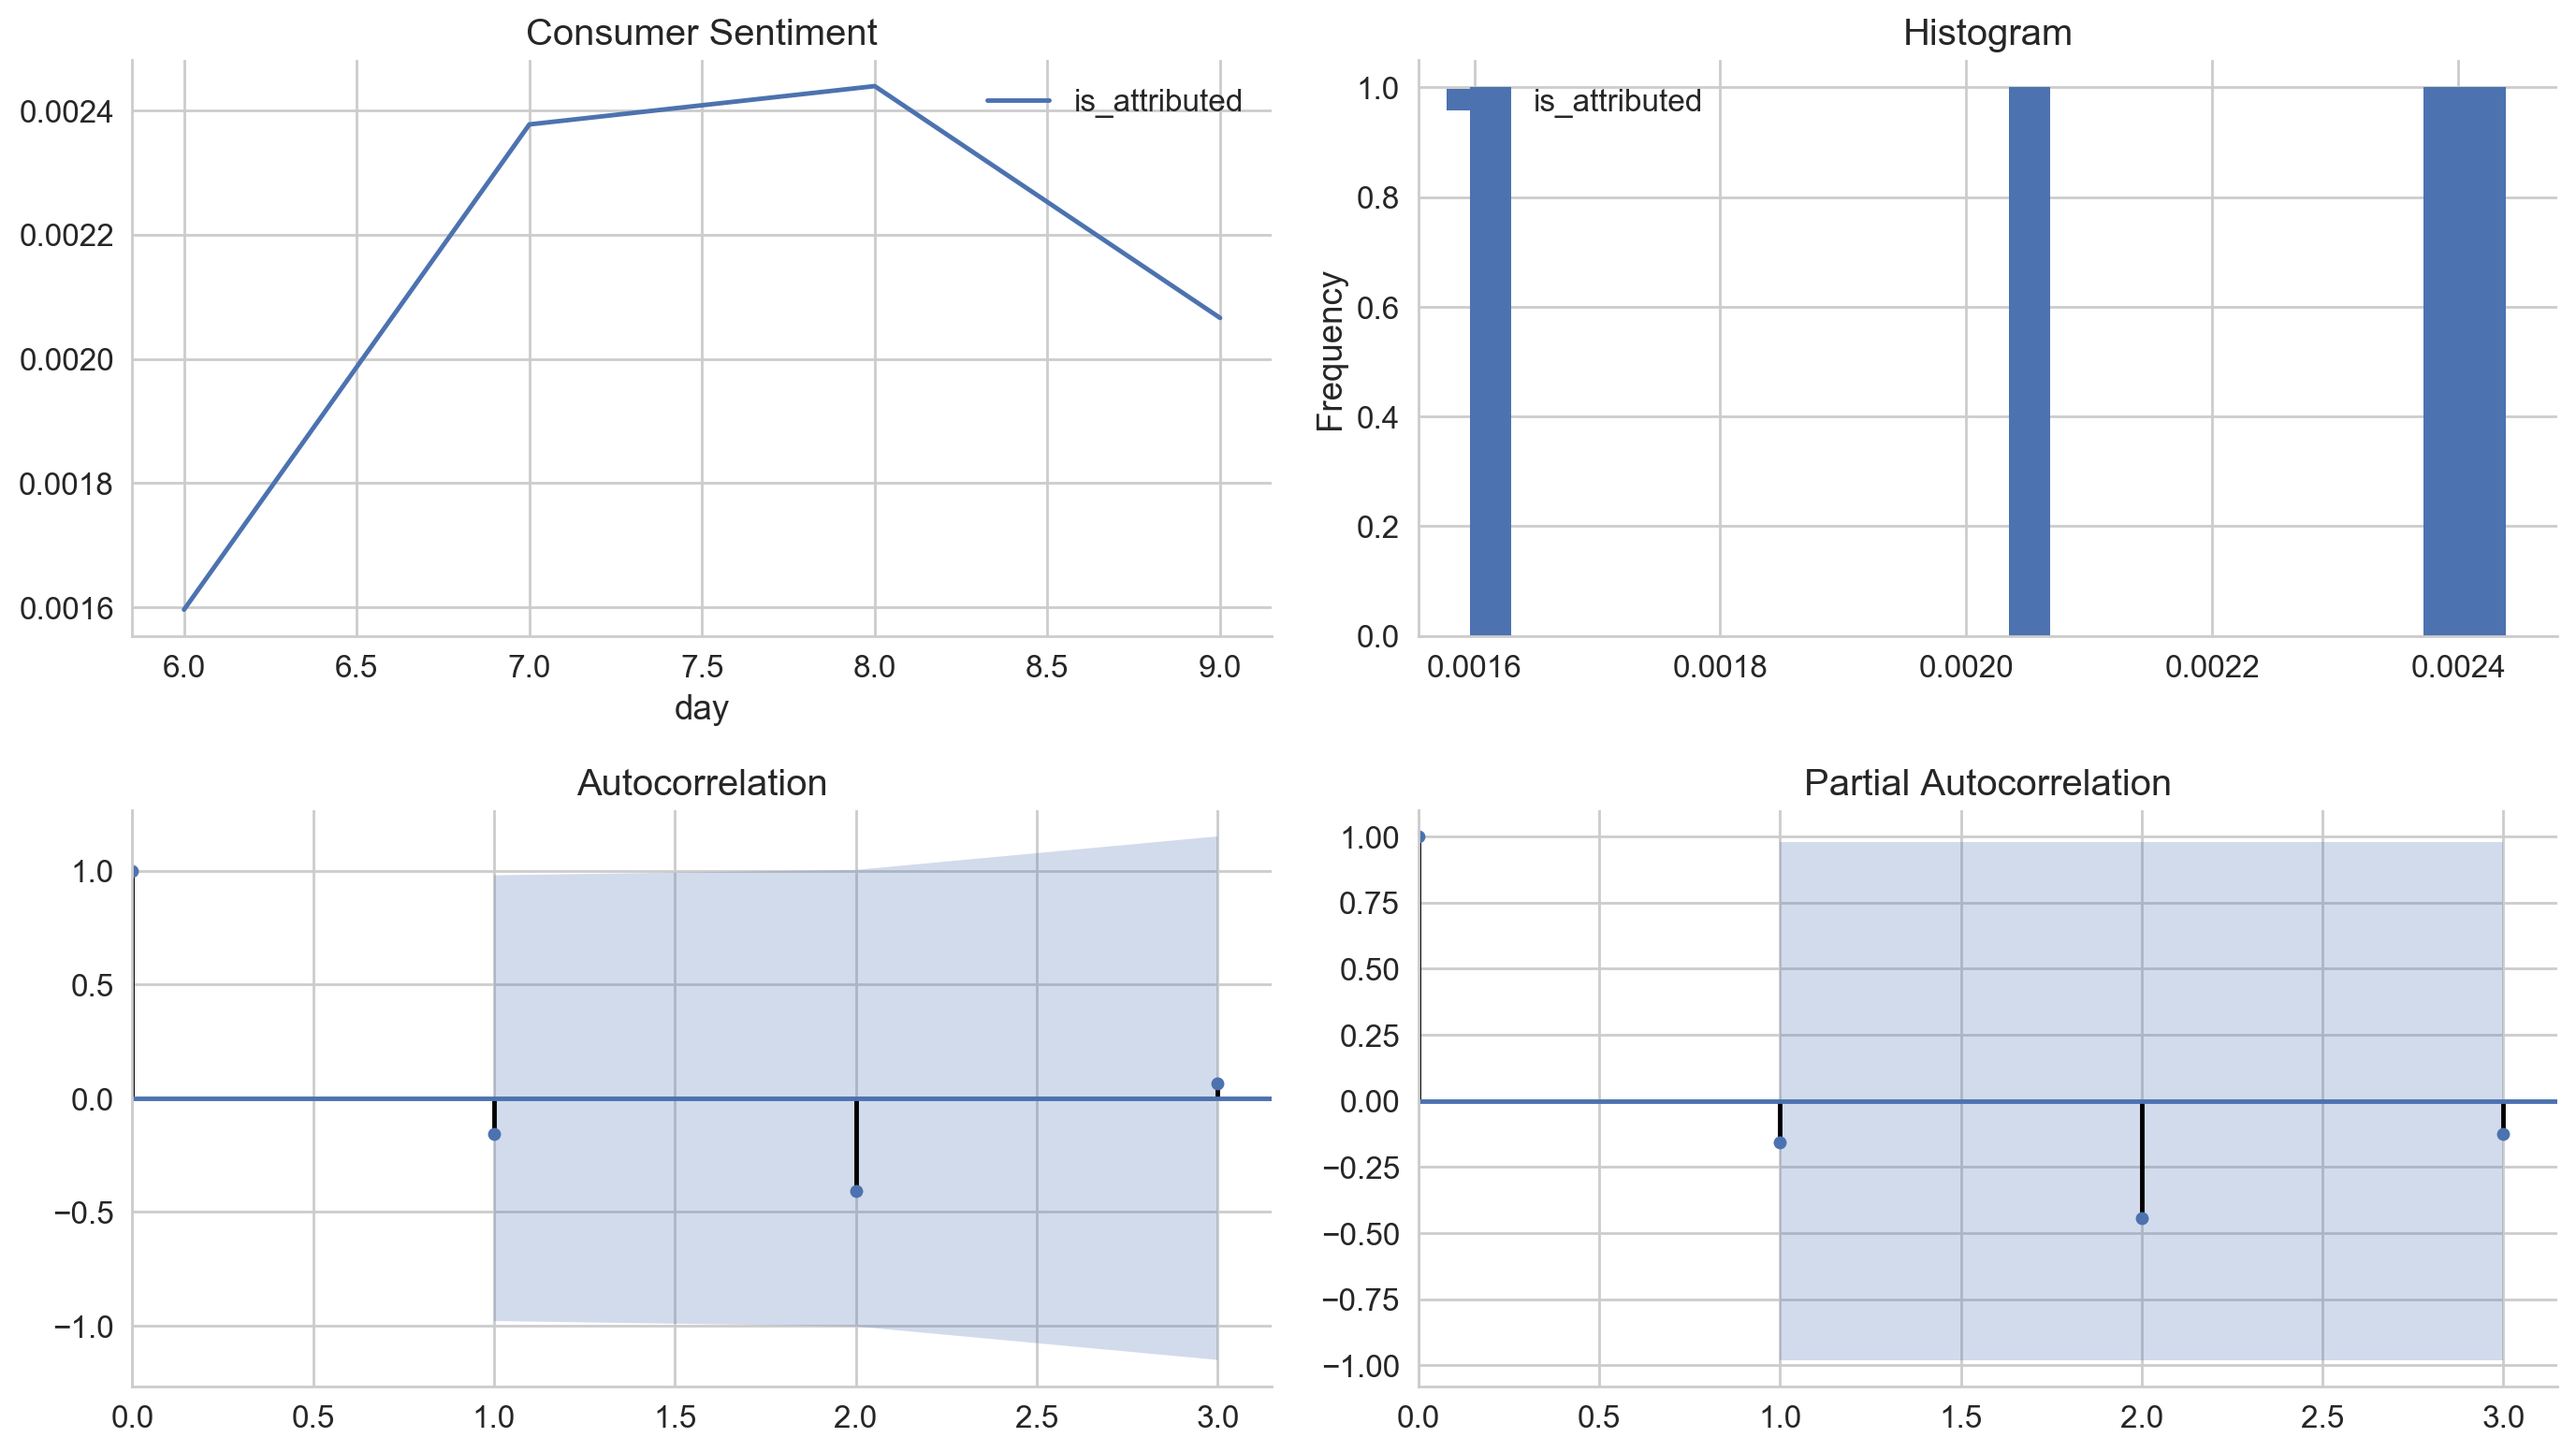

In [127]:
tsplot(train_smp[['day','is_attributed']].groupby(['day'], as_index=True).mean(), title='Consumer Sentiment', lags=3);

In [124]:
train_smp.head()

ip  app  device  os  channel          click_time attributed_time  \
0   87540   12       1  13      497 2017-11-07 09:30:38             NaT   
1  105560   25       1  17      259 2017-11-07 13:40:27             NaT   
2  101424   12       1  19      212 2017-11-07 18:05:24             NaT   
3   94584   13       1  13      477 2017-11-07 04:58:08             NaT   
4   68413   12       1   1      178 2017-11-09 09:00:09             NaT   

   is_attributed           click_rnd  day  hour  minute  second  
0              0 2017-11-07 10:00:00    7     9      30      38  
1              0 2017-11-07 14:00:00    7    13      40      27  
2              0 2017-11-07 18:00:00    7    18       5      24  
3              0 2017-11-07 05:00:00    7     4      58       8  
4              0 2017-11-09 09:00:00    9     9       0       9